# Setup

In [1]:
devtools::install_github("ropensci/rnaturalearthhires")
invisible(lapply(c(
  "Cairo", "dplyr", "tidyr", "duckdb", "dbplyr", "ggplot2",
  "rnaturalearth", "rnaturalearthdata", "rnaturalearthhires",
  "sf", "gdalcubes", "terra", "tidyterra",
  "car", "corrplot", "stringr", "Hmsc"
), library, character.only = TRUE))

gdalcubes_options(parallel = TRUE)

custom_palette <- c(
  "#0072B2",  "#D55E00", "#CC79A7", "#009E73", "#E69F00", "#56B4E9",
  "#F0E442", "#999999", "#000000"
)
options(
  repr.plot.width = 6, repr.plot.height = 3.5, repr.plot.res = 300,
  repr.plot.antialias = "subpixel",
  contrasts = c("contr.sum", "contr.poly"),
  ggplot2.discrete.fill = custom_palette,
  ggplot2.discrete.colour = custom_palette
)
theme_set(
  theme_bw() +
    theme(
      plot.title = element_text(face = "bold", hjust = 0.5),
      legend.position = "top",
      legend.direction = "horizontal",
      legend.box = "vertical",
      panel.grid.major.x = element_blank(),
      panel.grid.minor = element_blank(),
      strip.background = element_blank(),
      axis.title = element_text(size = rel(1.1), face = "bold"),
      axis.text = element_text(size = rel(1.1), face = "bold"),
      strip.text = element_text(size = rel(1.1), face = "bold")
    )
)

Using GitHub PAT from the git credential store.

Skipping install of 'rnaturalearthhires' from a github remote, the SHA1 (153b0ea5) has not changed since last install.
  Use `force = TRUE` to force installation


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: DBI


Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql



Attaching package: ‘rnaturalearthdata’


The following object is masked from ‘package:rnaturalearth’:

    countries110


Linking to GEOS 3.13.0, GDAL 3.10.2, PROJ 9.5.1; sf_use_s2() is TRUE

terra 1.8.42


Attaching package: ‘terra’


The following objects are masked from ‘package:gdalcubes’:

    animate, crop, size


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘tidyterra’


The following object is mas

# Data

In [2]:
con <- dbConnect(
  duckdb(), dbdir = "../processing/amfungi_lsu.duckdb", read_only = FALSE
)
inner_join(
  tbl(con, "occurances") |> select(sample_id, taxon_id, abundance, total),
  tbl(con, "samples") |> select(id, longitude, latitude),
  by = join_by(sample_id == id)
) |>
  inner_join(
    tbl(con, "taxa") |> select(taxa_id, Species),
    by = join_by(taxon_id == taxa_id)
  ) |>
  compute(name = "locations")

# Source:   table<locations> [?? x 7]
# Database: DuckDB v1.3.0 [robert@Linux 6.8.0-60-generic:R 4.3.3//home/robert/Public/Github/biotic_niche_modeling/processing/amfungi_lsu.duckdb]
   sample_id taxon_id abundance  total longitude latitude Species               
   <chr>     <chr>        <int>  <int>     <dbl>    <dbl> <chr>                 
 1 7805      MT832194        12 221538    -116.      43.3 Rhizophagus irregular…
 2 7806      MT832194        41 951993    -116.      43.3 Rhizophagus irregular…
 3 7814      MT832194         2 139418    -116.      43.3 Rhizophagus irregular…
 4 8077      MT832194         5  30383    -116.      43.3 Rhizophagus irregular…
 5 7929      MT832194         2  54553    -116.      43.3 Rhizophagus irregular…
 6 8007      MT832194         1    765    -122.      48.8 Rhizophagus irregular…
 7 7806      MT832194         1 951993    -116.      43.3 Rhizophagus irregular…
 8 7807      MT832194         1  20890     -99.6     24.9 Rhizophagus irregular…
 9 7806

In [3]:
occ <- collect(tbl(con, "occurances"))
loc <- collect(tbl(con, "locations"))
tax <- collect(tbl(con, "taxa"))

nrow(occ)
nrow(loc)

[1] 398074

[1] 398074

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


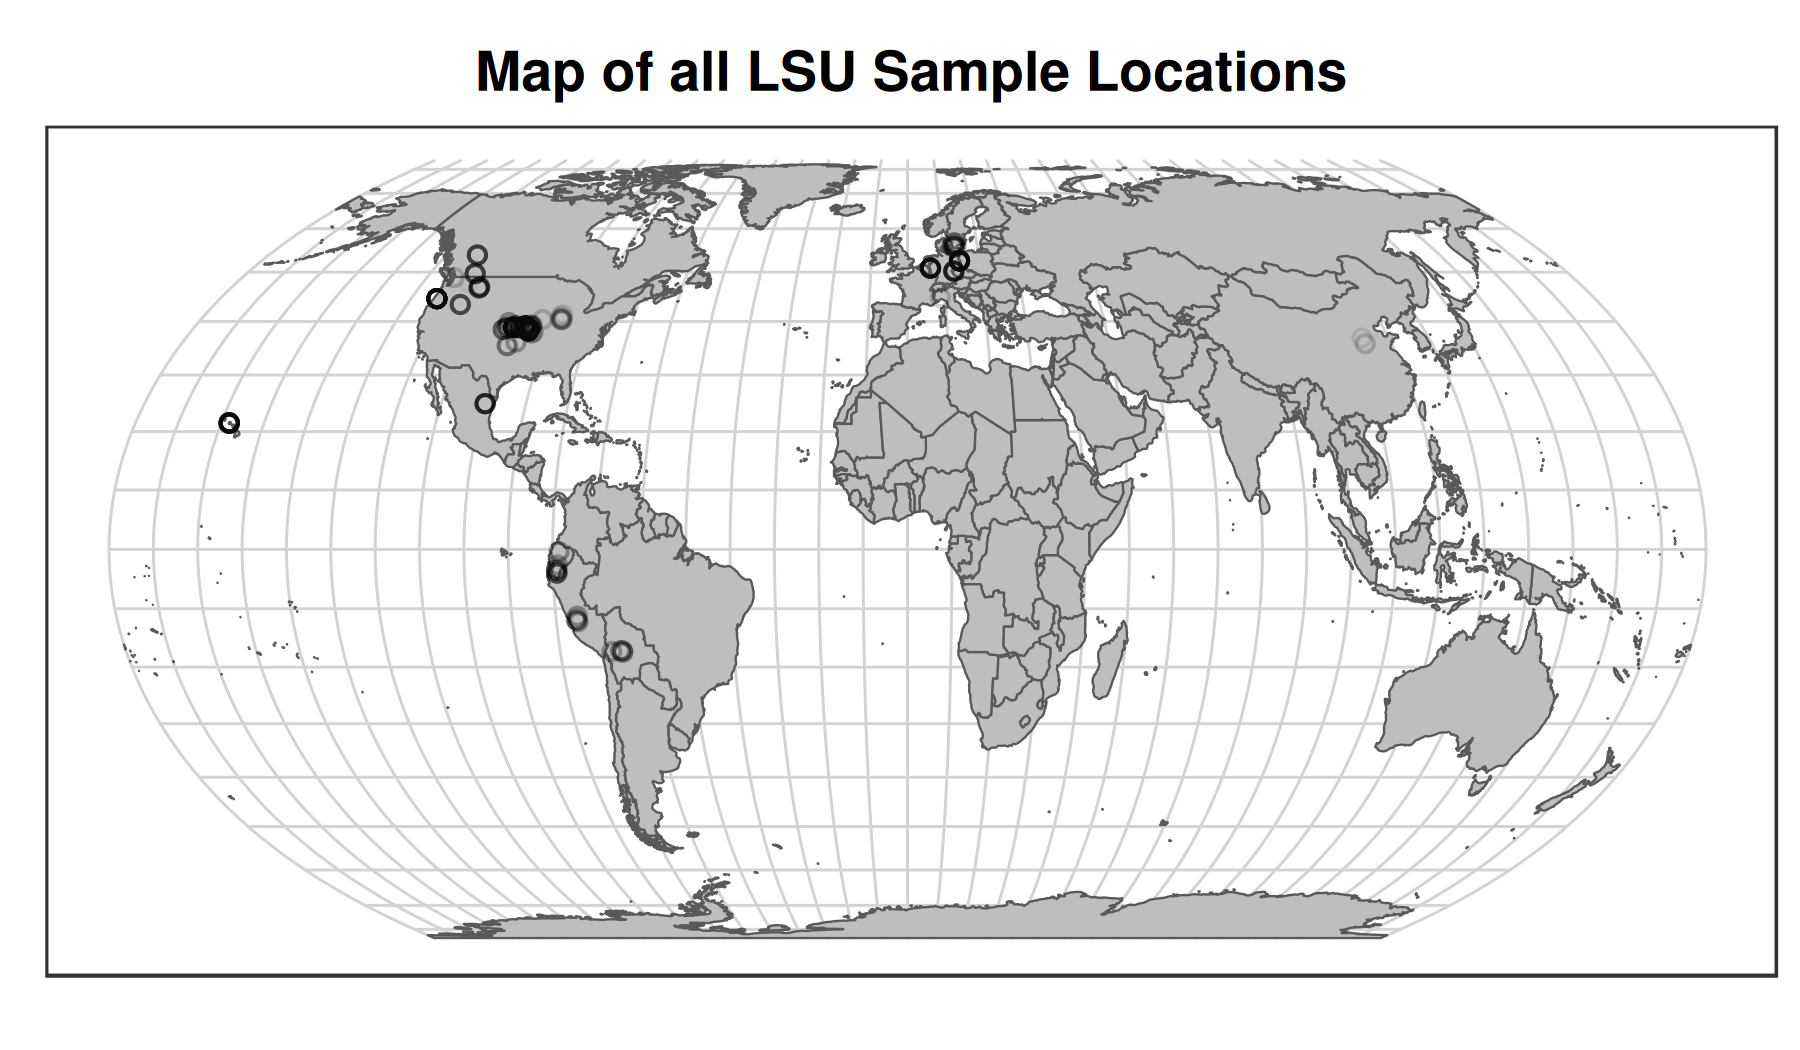

In [4]:
world <- ne_countries(scale = "medium", returnclass = "sf")
p <- ggplot(
  data = filter(tbl(con, "samples"), target_gene == "LSU")
) +
  geom_sf(
    data = world, fill = "grey", show.legend = FALSE
  ) +
  geom_point(
    aes(x = longitude, y = latitude),
    shape = 21, color = "black", fill = NA, alpha = 0.05
  ) +
  coord_sf(crs = "WGS84 +proj=eqearth", default_crs = "EPSG:4326") +
  theme(
    panel.grid = element_line(color = "lightgray", size = 0.25),
  ) +
  scale_x_continuous(breaks = seq(-180, 180, 10)) +
  scale_y_continuous(breaks = seq(-90, 90, 10)) +
  labs(
    x = element_blank(), y = element_blank(),
    title = "Map of all LSU Sample Locations"
  )
suppressWarnings(print(p))

In [5]:
count(tbl(con, "locations"), Species) |> collect() |> arrange(desc(n))


Species                    n     
1  Funneliformis mosseae      223099
2  Rhizophagus irregularis     64614
3  Funneliformis caledonius    48221
4  Claroideoglomus sp.         12782
5  Funneliformis sp.           12442
6  Sclerocystis sinuosa         9617
7  Claroideoglomus claroideum   4225
8  Microkamienskia perpusilla   2201
9  Glomeraceae_spp              2128
10 Glomus macrocarpum           2101
11 Septoglomus viscosum         1994
12 Rhizoglomus_sp               1834
13 Rhizophagus intraradices     1454
14 Microkamienskia divaricata   1430
15 Diversispora trimurales      1323
16 Halonatospora panshihalos    1093
17 Ambispora gerdemannii         891
18 Glomus sp.                    780
19 Otospora bareae               661
20 Rhizophagus fasciculatus      525
21 Dentiscutata heterogama       520
22 Claroideoglomus_sp            427
23 Innospora majewskii           408
24 Claroideoglomus candidum      308
25 Glomus_sp                     305
26 Acaulospora laevis            281
27 Septoglomus_sp                273
28 Oehlia diaphana               254
29 Septoglomus constrictum       246
30 Microdominikia litorea        194
31 Dominikia indica              183
32 Diversispora_sp               173
33 Acaulospora_sp                165
34 Claroideoglomus lamellosum    162
35 Claroideoglomus etunicatum    156
36 Rhizophagus proliferus        106
37 Funneliformis_sp               80
38 Paraglomus_sp                  72
39 Scutellospora_sp               45
40 Pacispora scintillans          37
41 Dominikia iranica              33
42 Redeckera megalocarpa          33
43 Gigaspora_sp                   32
44 Diversispora insculpta         31
45 Diversispora celata            31
46 Dominikia minuta               22
47 Ambispora_sp                   20
48 Acaulospora cavernata          18
49 Cetraspora_sp                  12
50 Desertispora omaniana          12
51 Archaeospora_sp                 9
52 Acaulospora spinosa             4
53 Entrophospora infrequens        4
54 Kamienskia bistrata             2
55 Gigaspora margarita             1

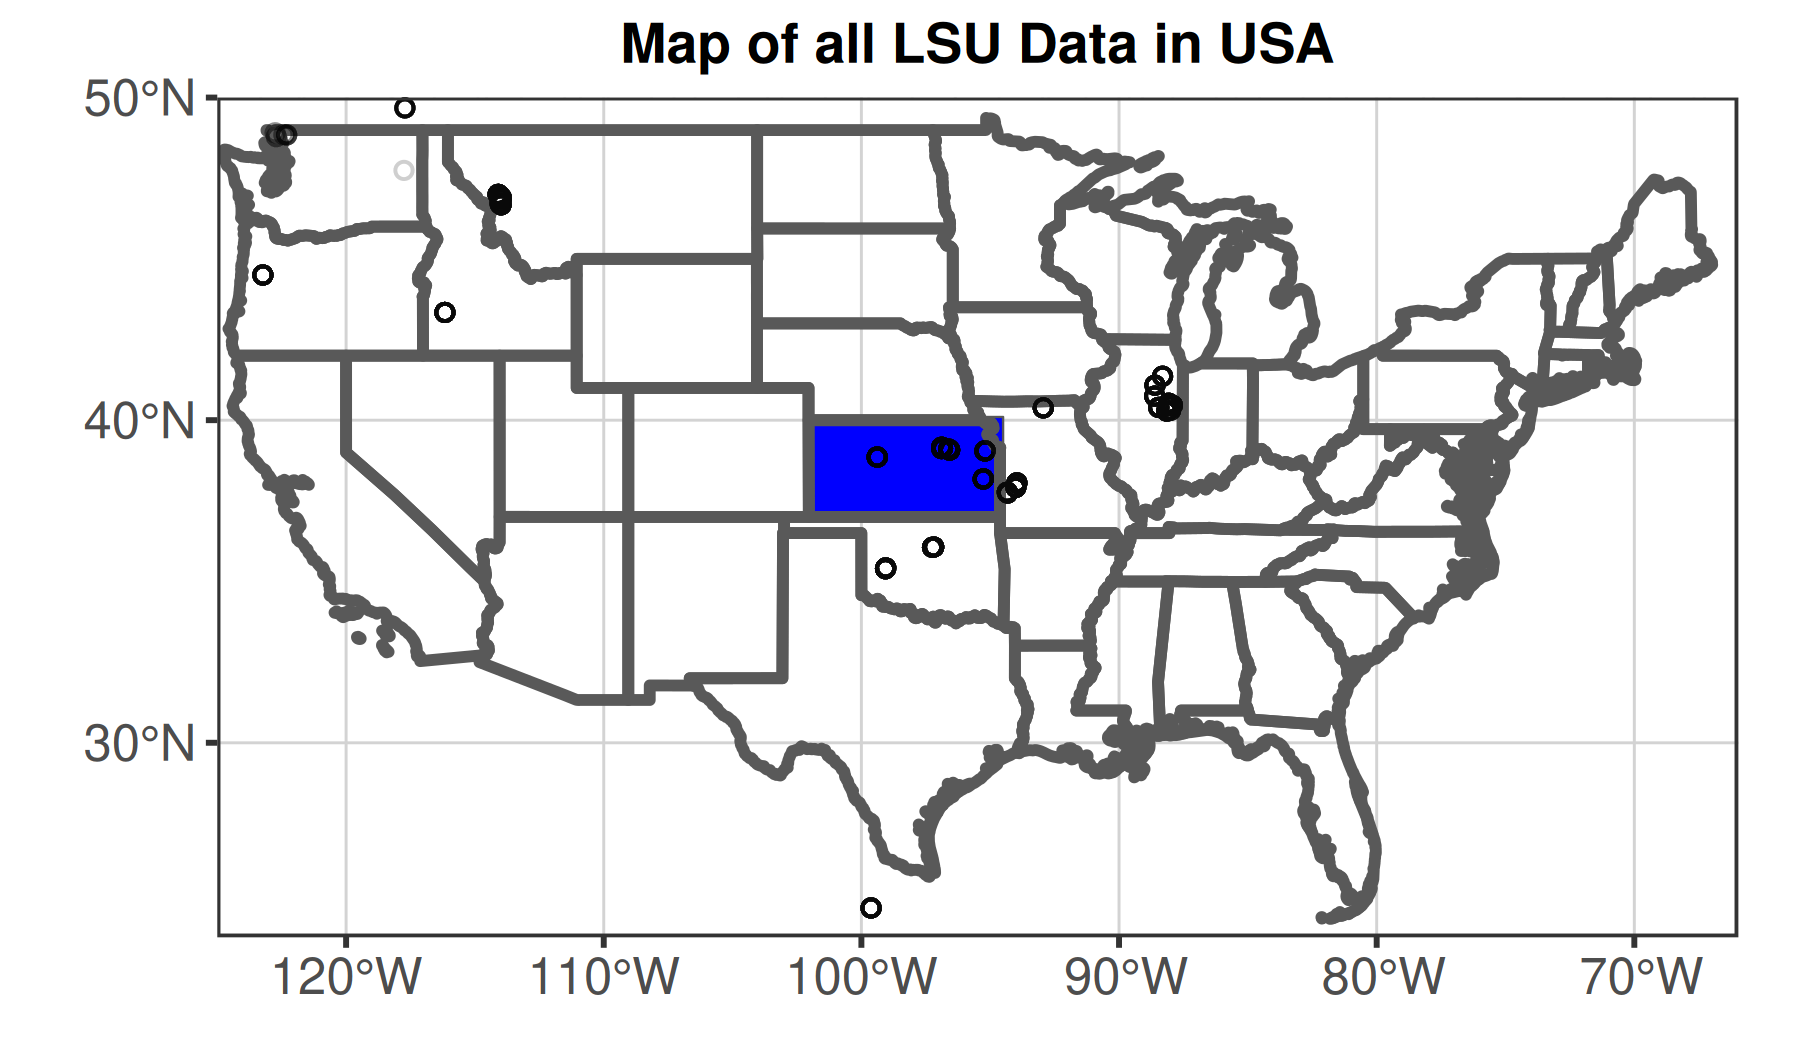

In [6]:
USA <- ne_states(country = "united states of america", returnclass = "sf")
p <- ggplot(
  # data = filter(tbl(con, "samples"), target_gene == "LSU")
  data = tbl(con, "locations")
) +
  geom_sf(
    data = st_as_sfc(
      st_bbox(c(xmin = -102.2, xmax = -94.5, ymin = 36.9, ymax = 40.1), crs = 4326)
    ), fill = "blue"
  ) +
  geom_sf(
    data = USA, fill = NA, linewidth = 1, show.legend = FALSE
  ) +
  geom_point(
    aes(x = longitude, y = latitude),
    shape = 21, color = "black", fill = NA, alpha = 0.05
  ) +
  coord_sf(
    crs = "WGS84", default_crs = "WGS84",
    # xlim = c(-102.2, -94.5), ylim = c(36.9, 40.1), expand = FALSE
    xlim = c(-125, -66), ylim = c(24, 50), expand = FALSE
  ) +
  theme(
    panel.grid = element_line(color = "lightgray", size = 0.25),
  ) +
  scale_x_continuous(breaks = seq(-180, 180, 10)) +
  scale_y_continuous(breaks = seq(-90, 90, 10)) +
  labs(
    x = element_blank(), y = element_blank(),
    title = "Map of all LSU Data in USA"
  )
suppressWarnings(print(p))

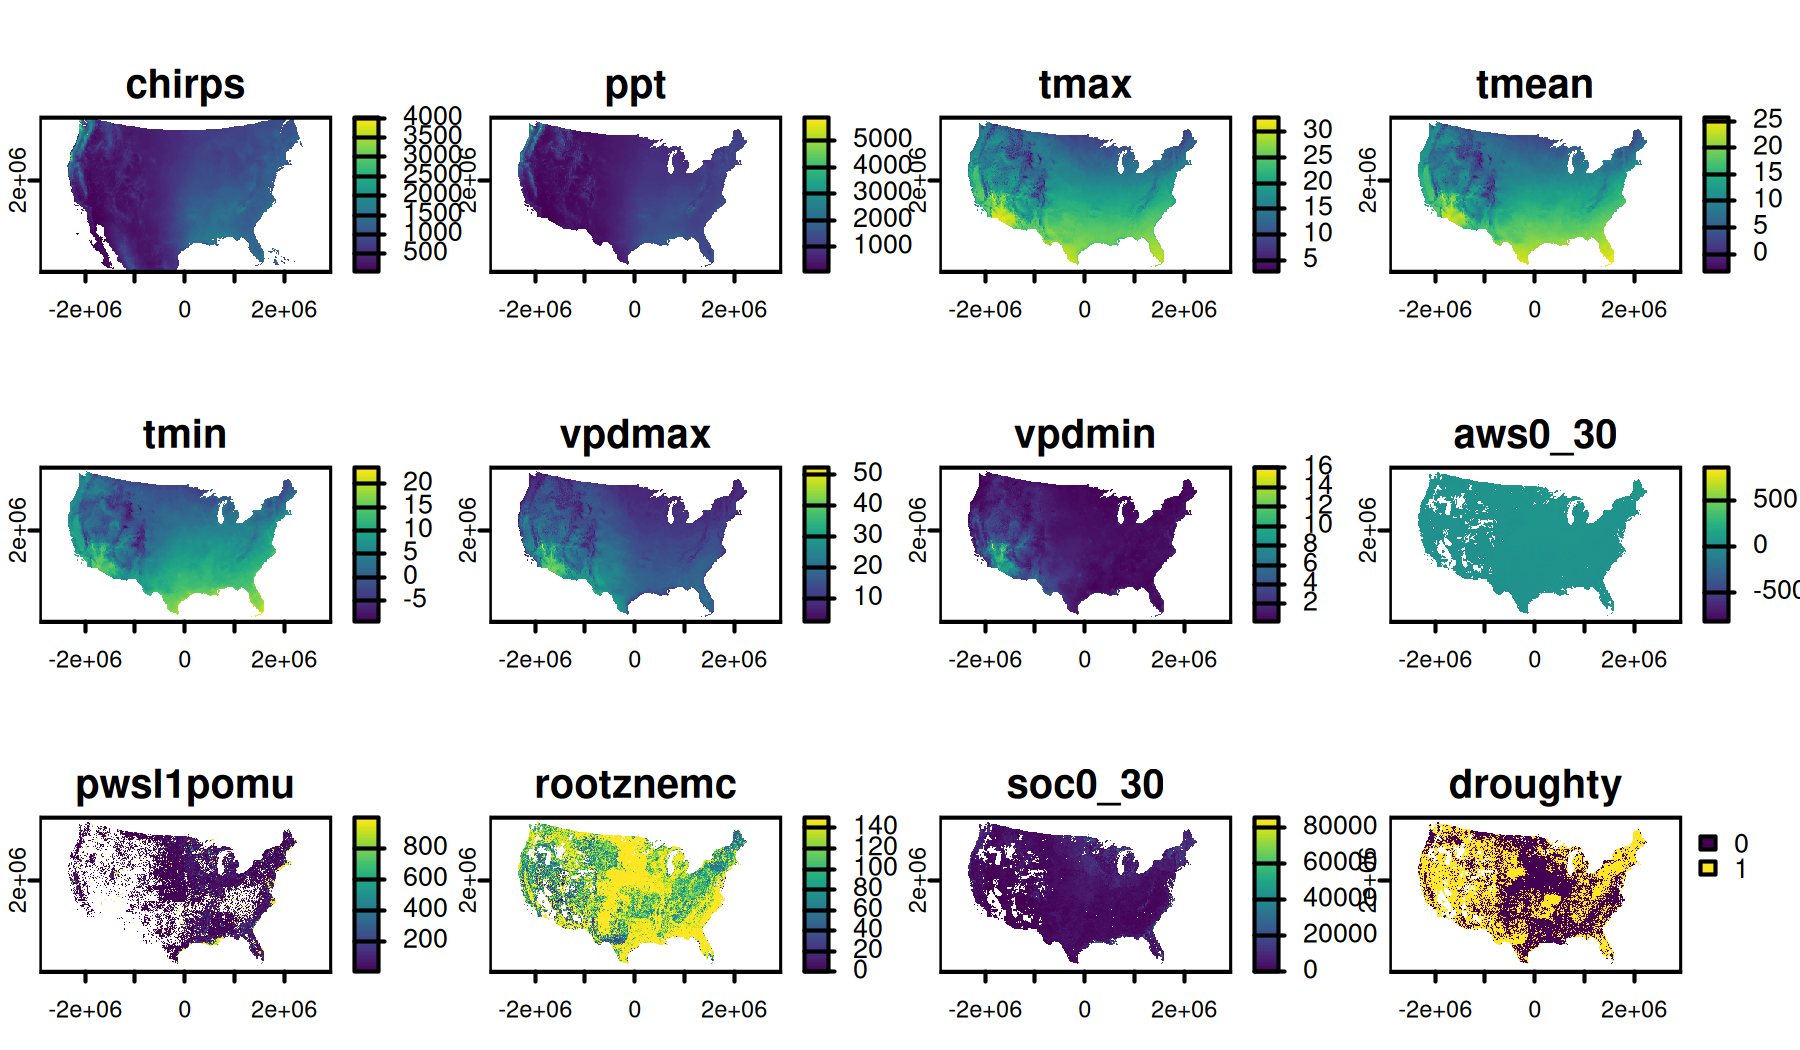

In [7]:
gis_dataset <- rast("../processing/gis/gis_data_1km.nc")
plot(gis_dataset)

# Midwest Only

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


Species            n   
1  Glomeraceae_spp    2128
2  Rhizoglomus_sp     1834
3  Claroideoglomus_sp  427
4  Glomus_sp           305
5  Septoglomus_sp      273
6  Diversispora_sp     173
7  Acaulospora_sp      165
8  Funneliformis_sp     80
9  Paraglomus_sp        72
10 Scutellospora_sp     45
11 Gigaspora_sp         32
12 Ambispora_sp         20
13 Cetraspora_sp        12
14 Archaeospora_sp       9

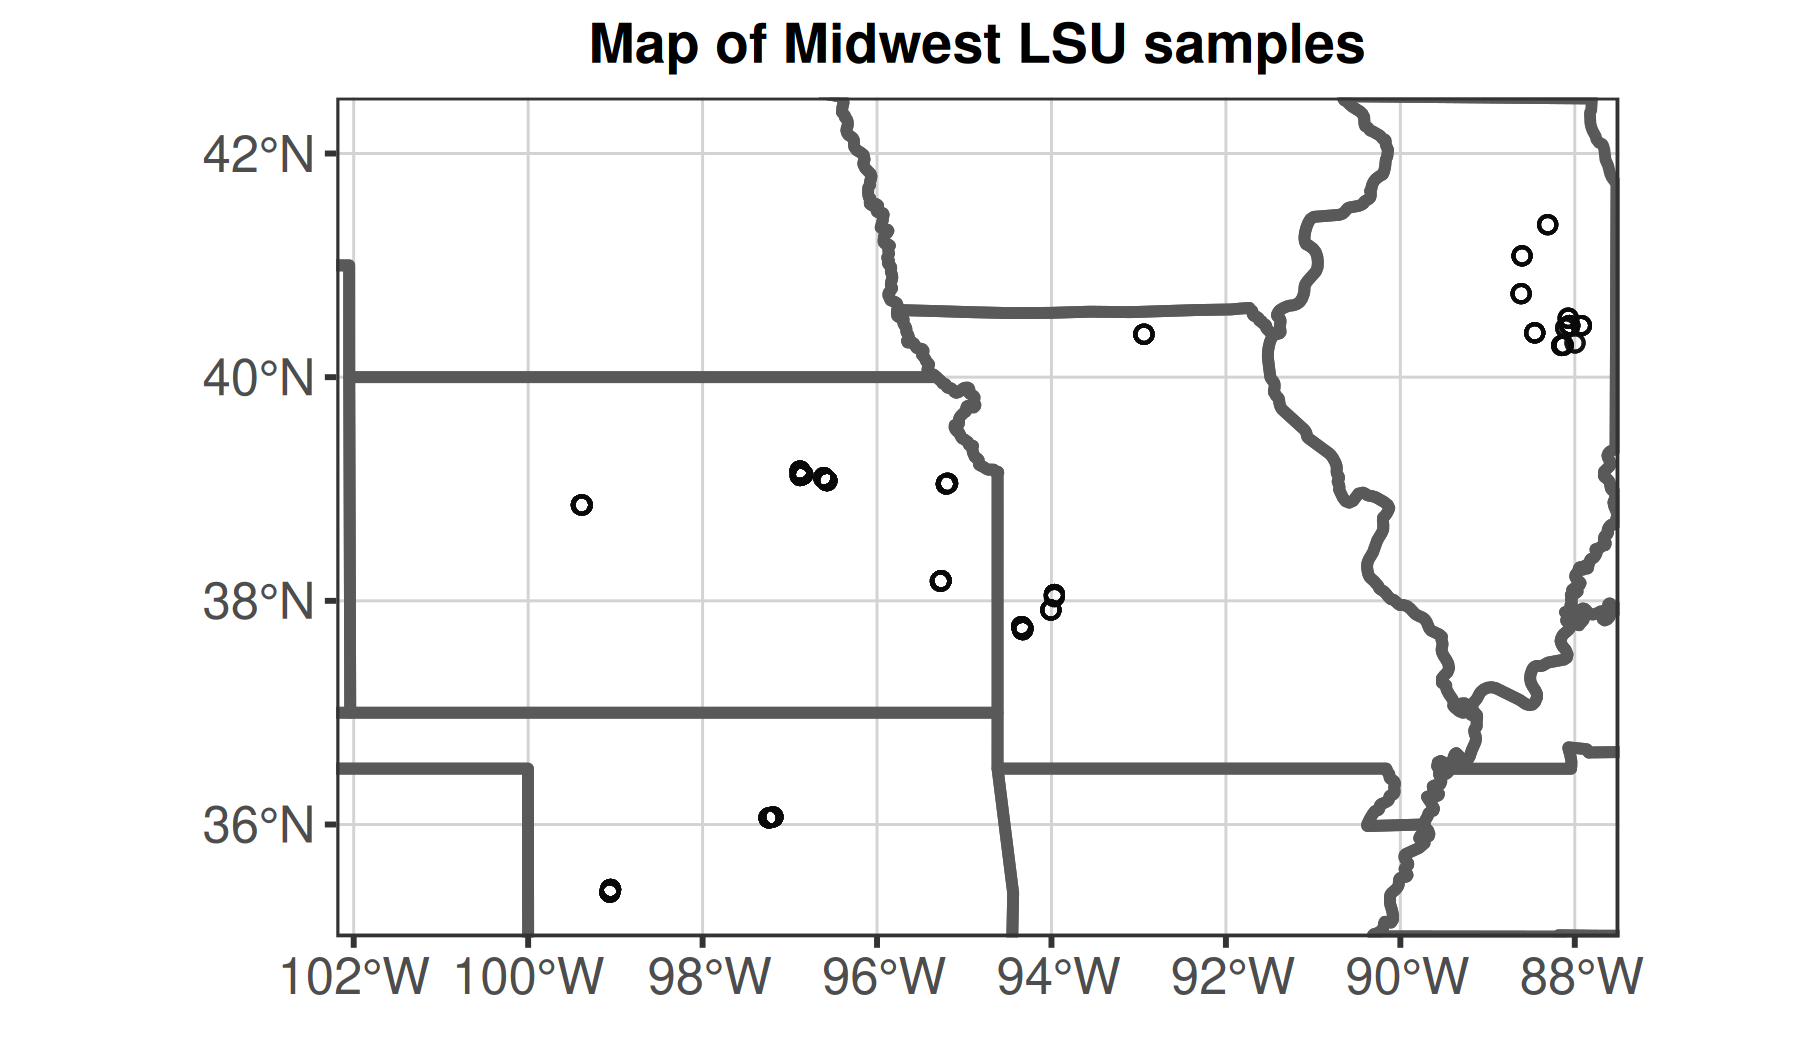

In [8]:
midwest_locations <- st_as_sf(
  collect(tbl(con, "locations")),
  coords = c('longitude', 'latitude'),
  crs = 4326
) |>
  st_crop(
    st_bbox(
      c(xmin = -102.2, xmax = -87.5, ymin = 35, ymax = 42.5),
      crs = 4326
    )
  )
USA <- ne_states(country = "united states of america", returnclass = "sf")
p <- ggplot(
) +
  geom_sf(
    data = USA, fill = NA, linewidth = 1, show.legend = FALSE
  ) +
  geom_sf(
    data = midwest_locations,
    shape = 21, color = "black", fill = NA, alpha = 0.05
  ) +
  coord_sf(
    crs = "WGS84", default_crs = "WGS84",
    xlim = c(-102.2, -87.5), ylim = c(35, 42.5), expand = FALSE
  ) +
  theme(
    panel.grid = element_line(color = "lightgray", size = 0.25),
  ) +
  scale_x_continuous(breaks = seq(-180, 180, 2)) +
  scale_y_continuous(breaks = seq(-90, 90, 2)) +
  labs(
    x = element_blank(), y = element_blank(),
    title = "Map of Midwest LSU samples"
  )
suppressWarnings(print(p))
count(st_drop_geometry(midwest_locations), Species) |> arrange(desc(n))

Warning message:
“[extract] transforming vector data to the CRS of the raster”


[1] "sample_id"  "taxon_id"   "abundance"  "total"      "Species"   
 [6] "chirps"     "ppt"        "tmax"       "tmean"      "tmin"      
[11] "vpdmax"     "vpdmin"     "aws0_30"    "pwsl1pomu"  "rootznemc" 
[16] "soc0_30"    "droughty"   "proportion"

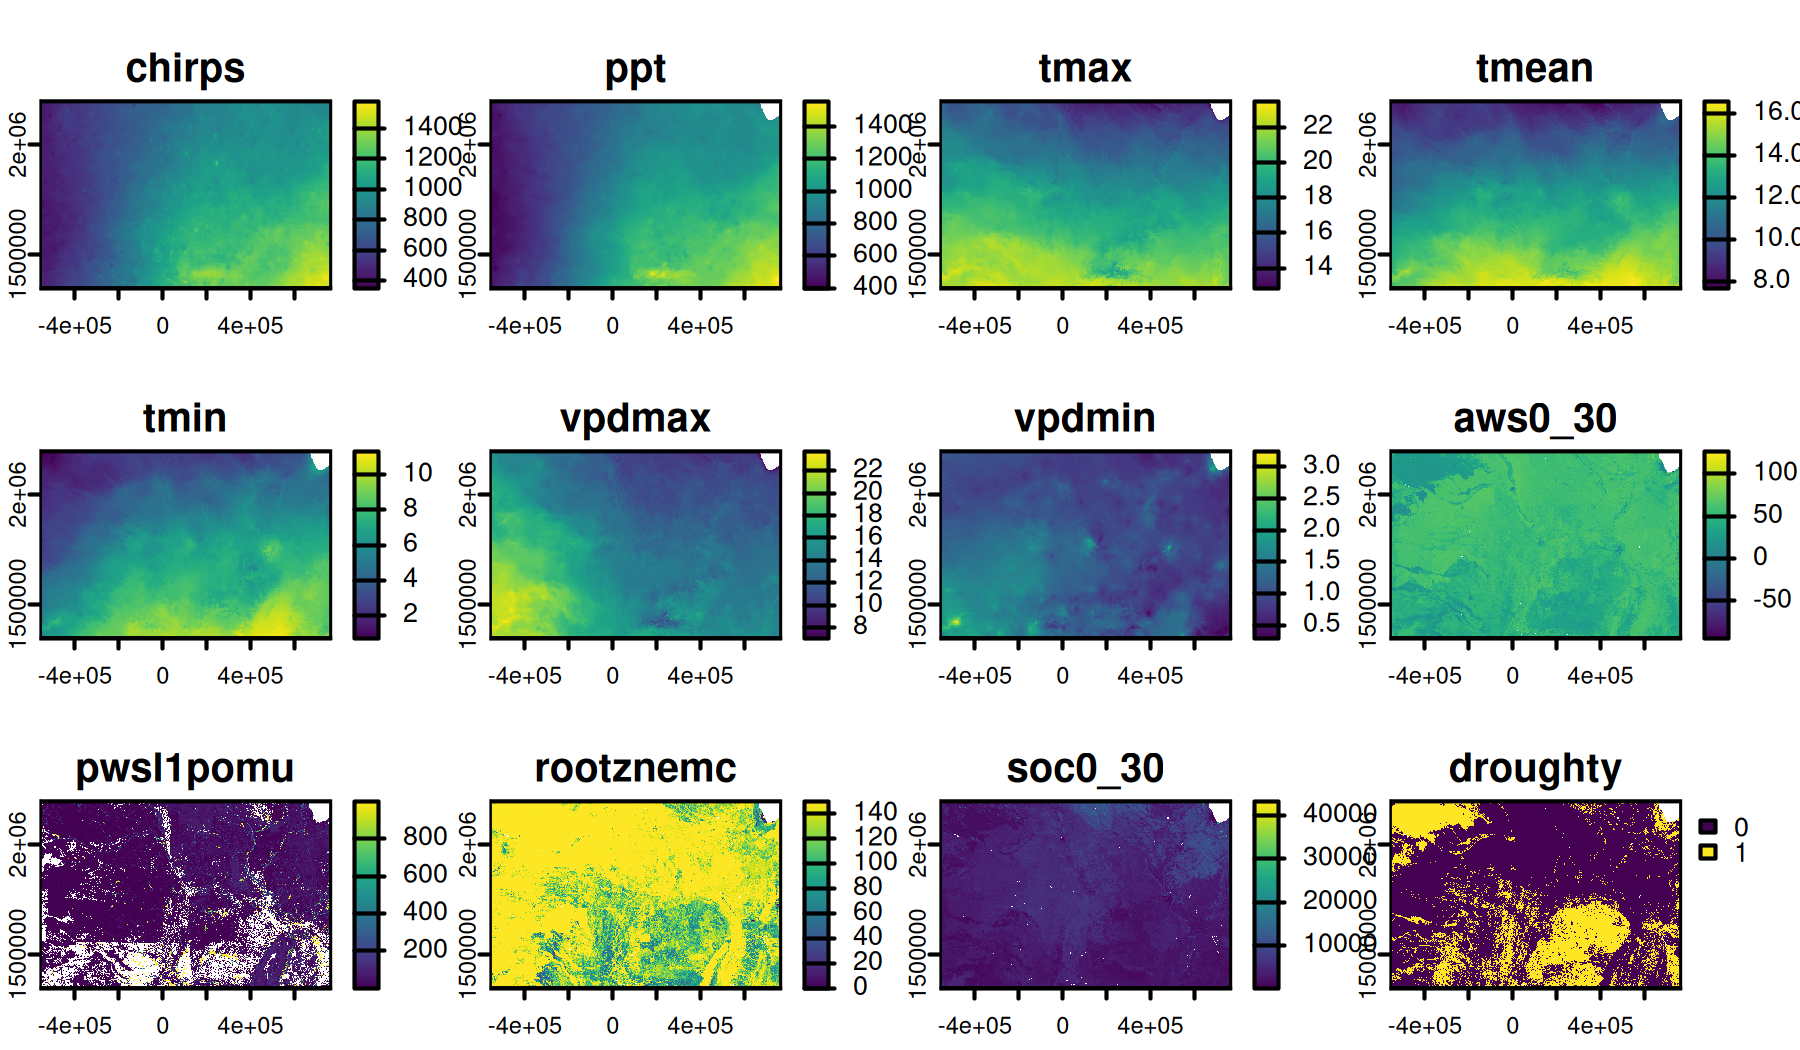

In [9]:
gis_dataset <- rast("../processing/gis/gis_data_1km.nc")
midwest_points <- midwest_locations
midwest_gis_dataset <- crop(
  gis_dataset,
  project(
    ext(c(-102.2, -87.5, 35, 42.5)),
    from = "EPSG:4326",
    to = "EPSG:5070"
  )
)
plot(midwest_gis_dataset)
extraction <- extract(midwest_gis_dataset, midwest_points)
dataset <- st_drop_geometry(cbind(midwest_points, extraction[, -1]))
dataset$proportion <- dataset$abundance/dataset$total
colnames(dataset)

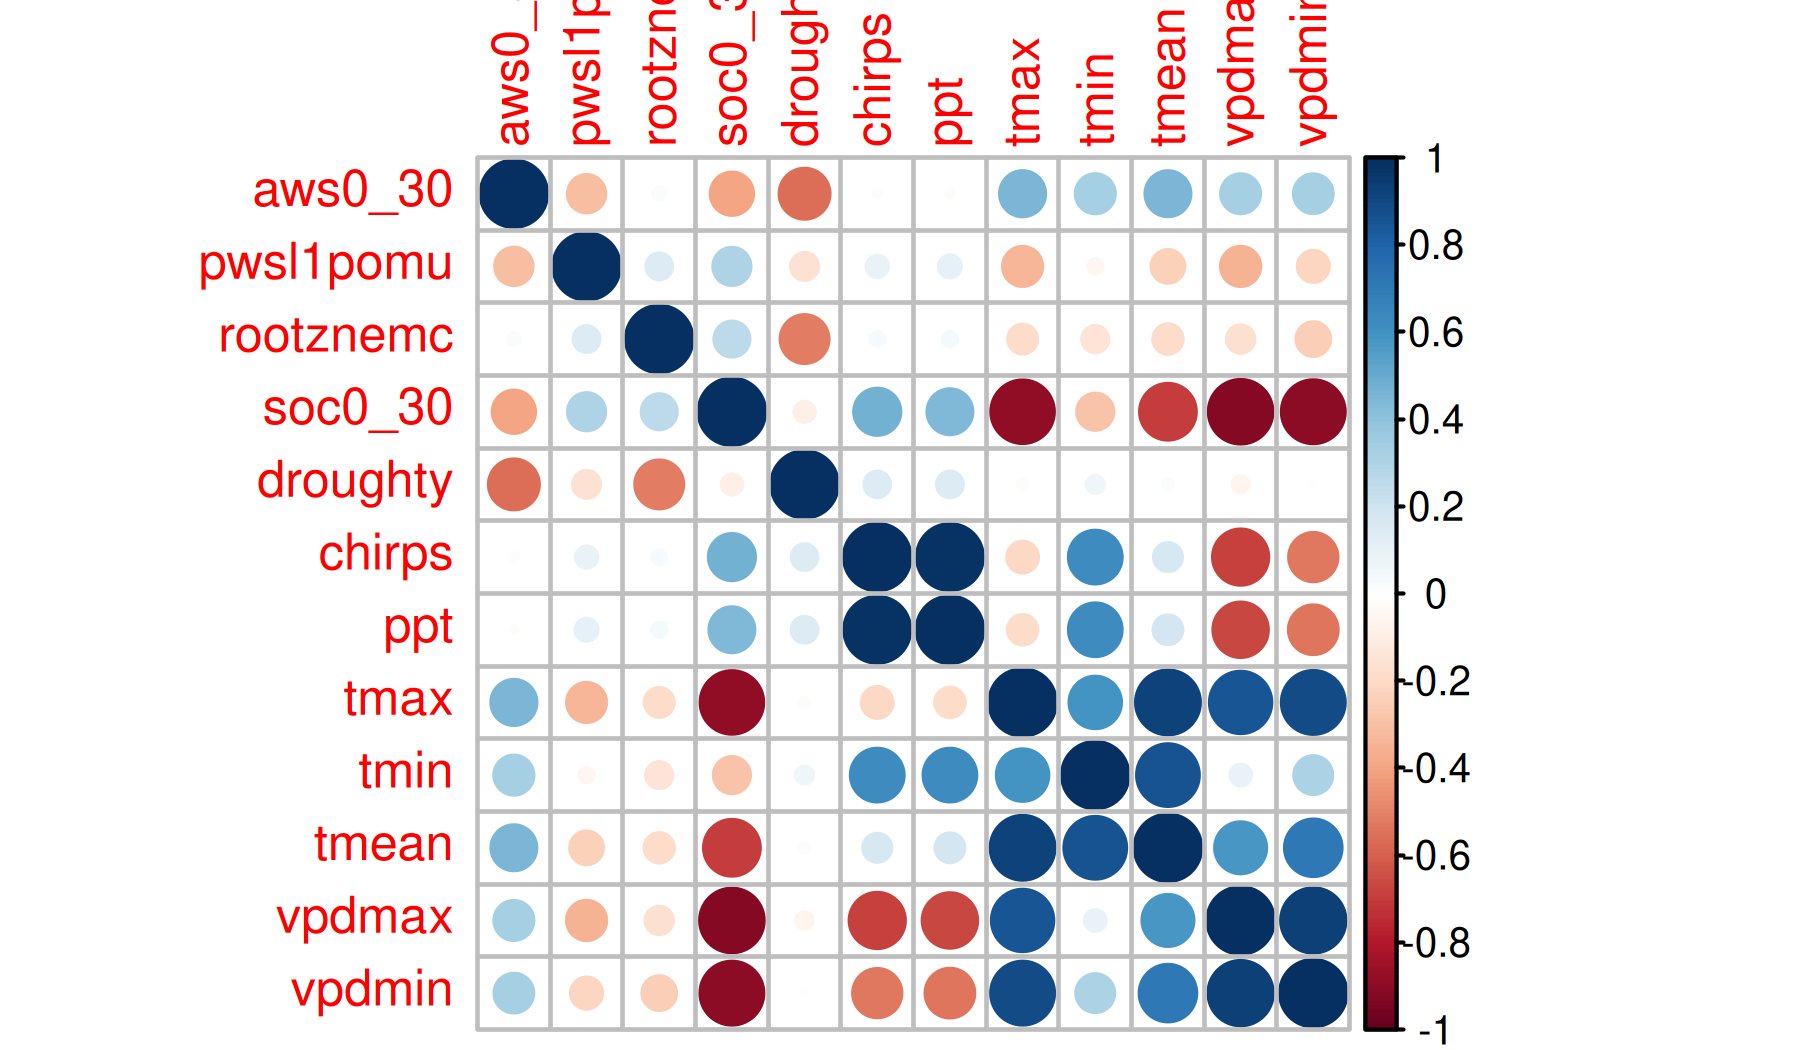

In [12]:
corrplot(cor(dataset[
  ,
  c(
    "aws0_30", # Available water storage estimate, expressed in mm
    "pwsl1pomu", # Potential Wetland Soil Landscapes is expressed as percentage
    "rootznemc", # Root zone depth, expressed in cm
    "soc0_30", # Soil organic carbon stock estimate, grams C per square meter
    "droughty", # “1” for a drought vulnerable soil or “0” for a non-droughty
    "chirps", # Annual Precipitation in 2020 (mm)
    "ppt", # Mean Precip 30 year normal (mm)
    "tmax", # Max Temp 30 year normal (C)
    "tmin", # Min Temp 30 year normal (C)
    "tmean",# Mean Temp 30 year normal (C)
    "vpdmax", # Daily Maximum Vapor Pressure Deficit 30 year normal (hPa)
    "vpdmin" # Daily Minimum Vapor Pressure Deficit 30 year normal (hPa)
  )
], use = "complete.obs"), method = "circle", type = "full")

In [14]:
species_names <- c(
  "Rhizoglomus_sp", "Claroideoglomus_sp", "Glomus_sp",
  "Septoglomus_sp", "Diversispora_sp", "Acaulospora_sp"
)
# pwsl1pomu # Removed due to NA values
predictors <- c(
  "aws0_30", # Available water storage estimate, expressed in mm
  "rootznemc", # Root zone depth, expressed in cm
  "soc0_30", # Soil organic carbon stock estimate, grams C per square meter
  "droughty", # “1” for a drought vulnerable soil or “0” for a non-droughty
  "tmax", # Max Temp 30 year normal (C)
  "tmin", # Min Temp 30 year normal (C)
  "tmean",# Mean Temp 30 year normal (C)
  "vpdmax", # Daily Maximum Vapor Pressure Deficit 30 year normal (hPa)
  "vpdmin", # Daily Minimum Vapor Pressure Deficit 30 year normal (hPa)
  "chirps" # Annual Precipitation in 2020 (mm)
)
dataset_wide <- pivot_wider(
  dataset[dataset$Species %in% species_names, ],
  names_from = Species, values_from = proportion
)

m <- Hmsc(
  Y = dataset_wide[species_names],
  XData = dataset_wide[predictors],
  XFormula = ~
    aws0_30 +
    # pwsl1pomu +
    rootznemc +
    soc0_30 +
    # droughty +
    tmax +
    # tmin +
    # tmean +
    vpdmax +
    # vpdmin +
    chirps,
  studyDesign = data.frame(sample = as.factor(row.names(dataset_wide))),
  ranLevels = list(
    sample = HmscRandomLevel(units = as.factor(row.names(dataset_wide)))
  )
)
m <- sampleMcmc(
  m,
  thin = 10,
  samples = 100,
  transient = 500,
  nChains = 16,
  nParallel = 16,
  verbose = 1
)


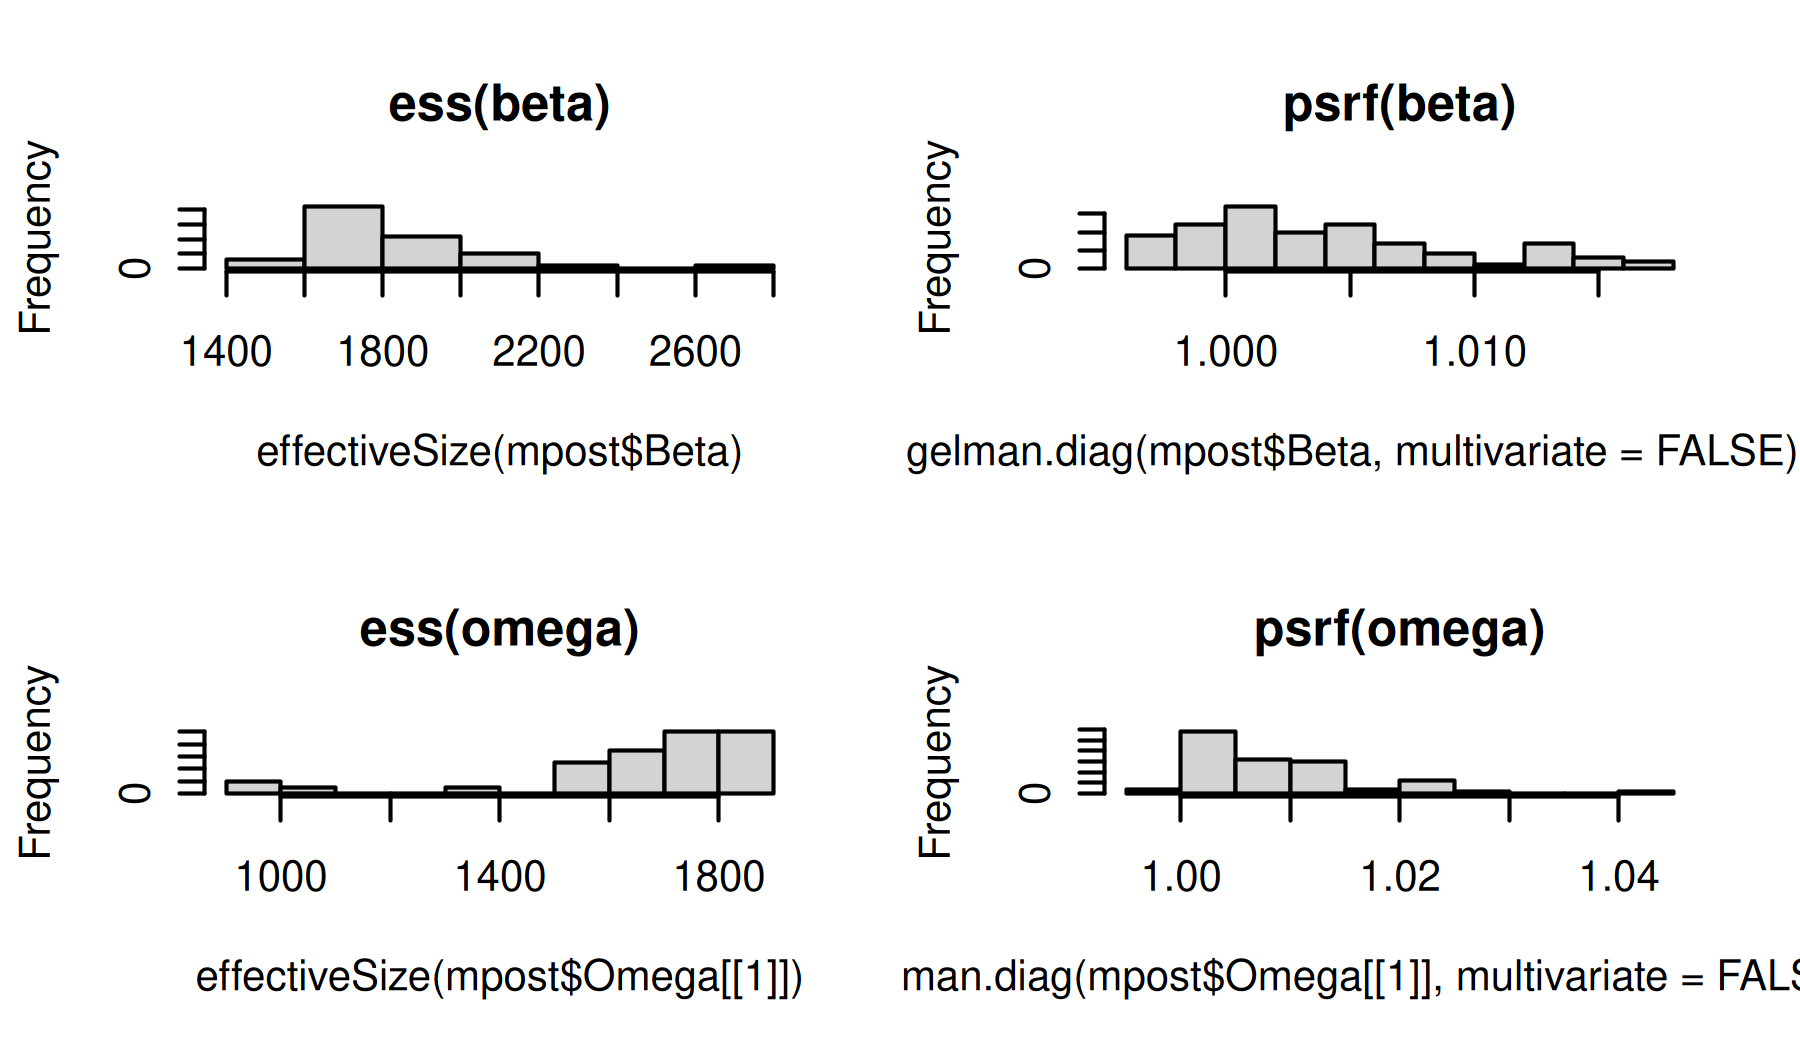

In [15]:
mpost = convertToCodaObject(m)
par(mfrow=c(2,2))
hist(effectiveSize(mpost$Beta), main="ess(beta)")
hist(gelman.diag(mpost$Beta, multivariate=FALSE)$psrf, main="psrf(beta)")
hist(effectiveSize(mpost$Omega[[1]]), main="ess(omega)")
hist(gelman.diag(mpost$Omega[[1]], multivariate=FALSE)$psrf, main="psrf(omega)")

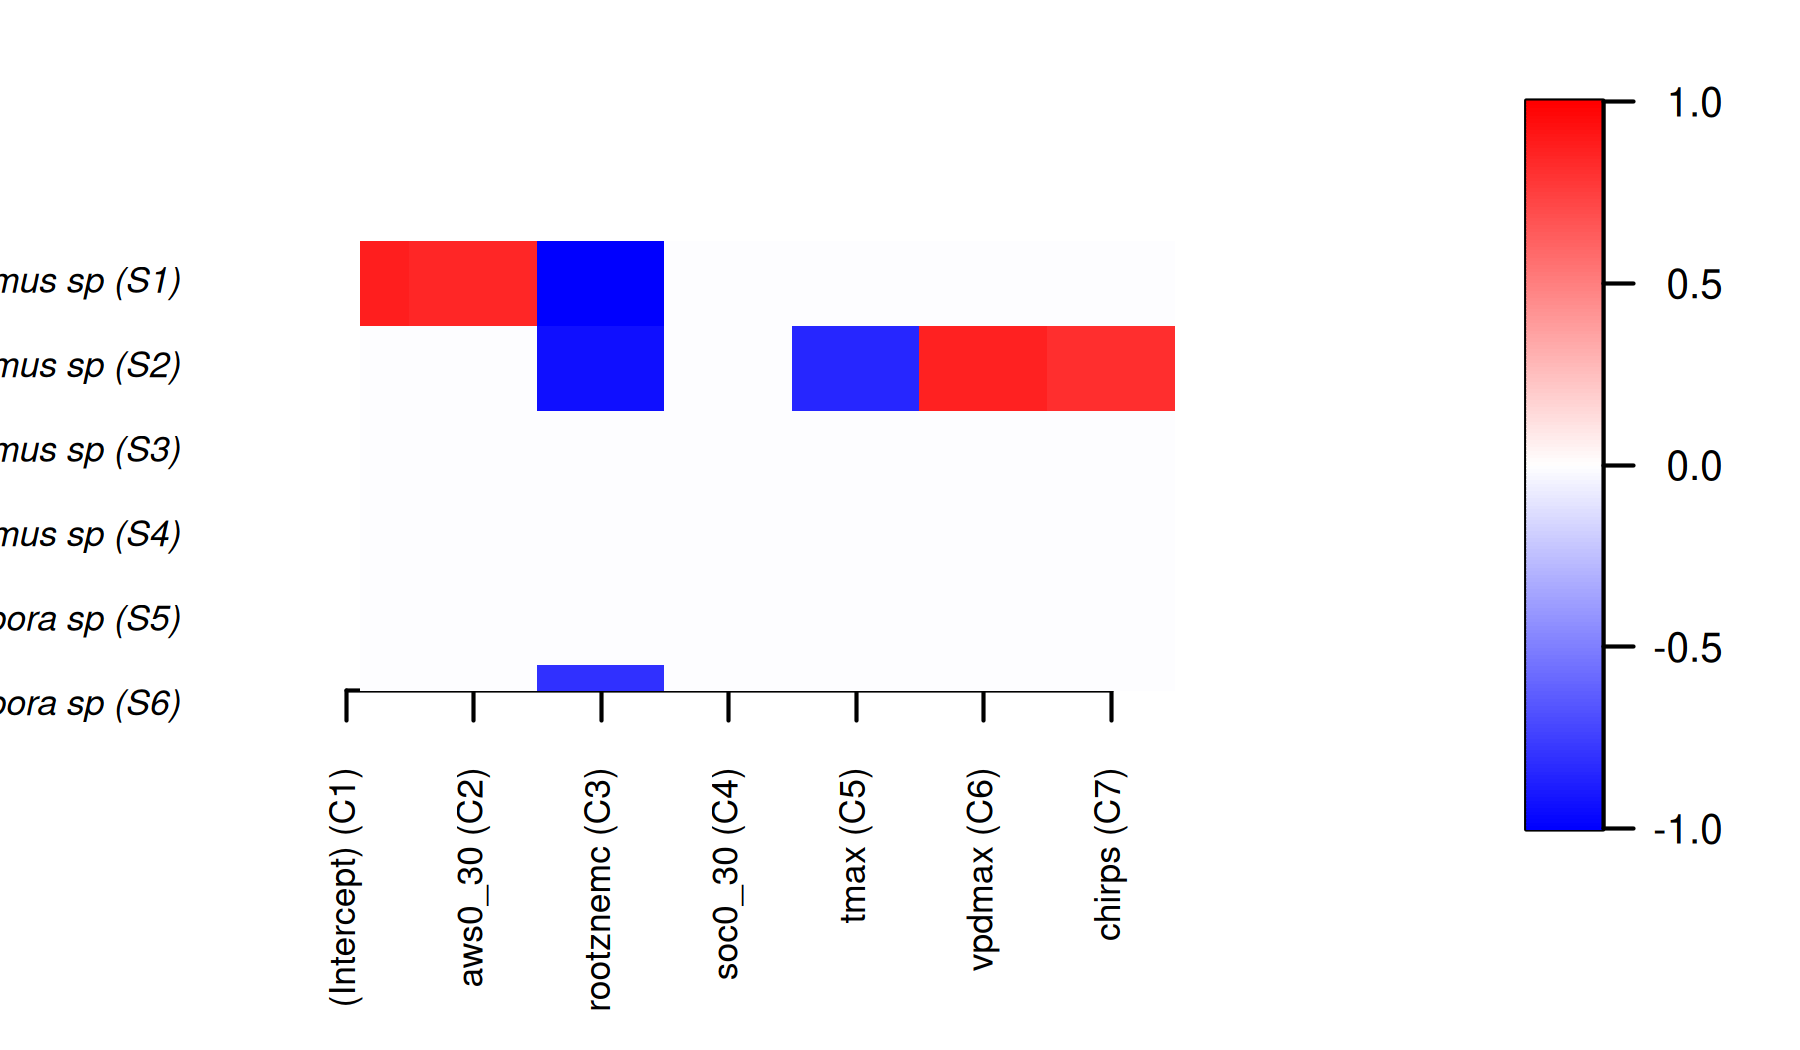

In [16]:
postBeta = getPostEstimate(m, parName="Beta")
plotBeta(m, post=postBeta, param="Support", supportLevel = 0.9)

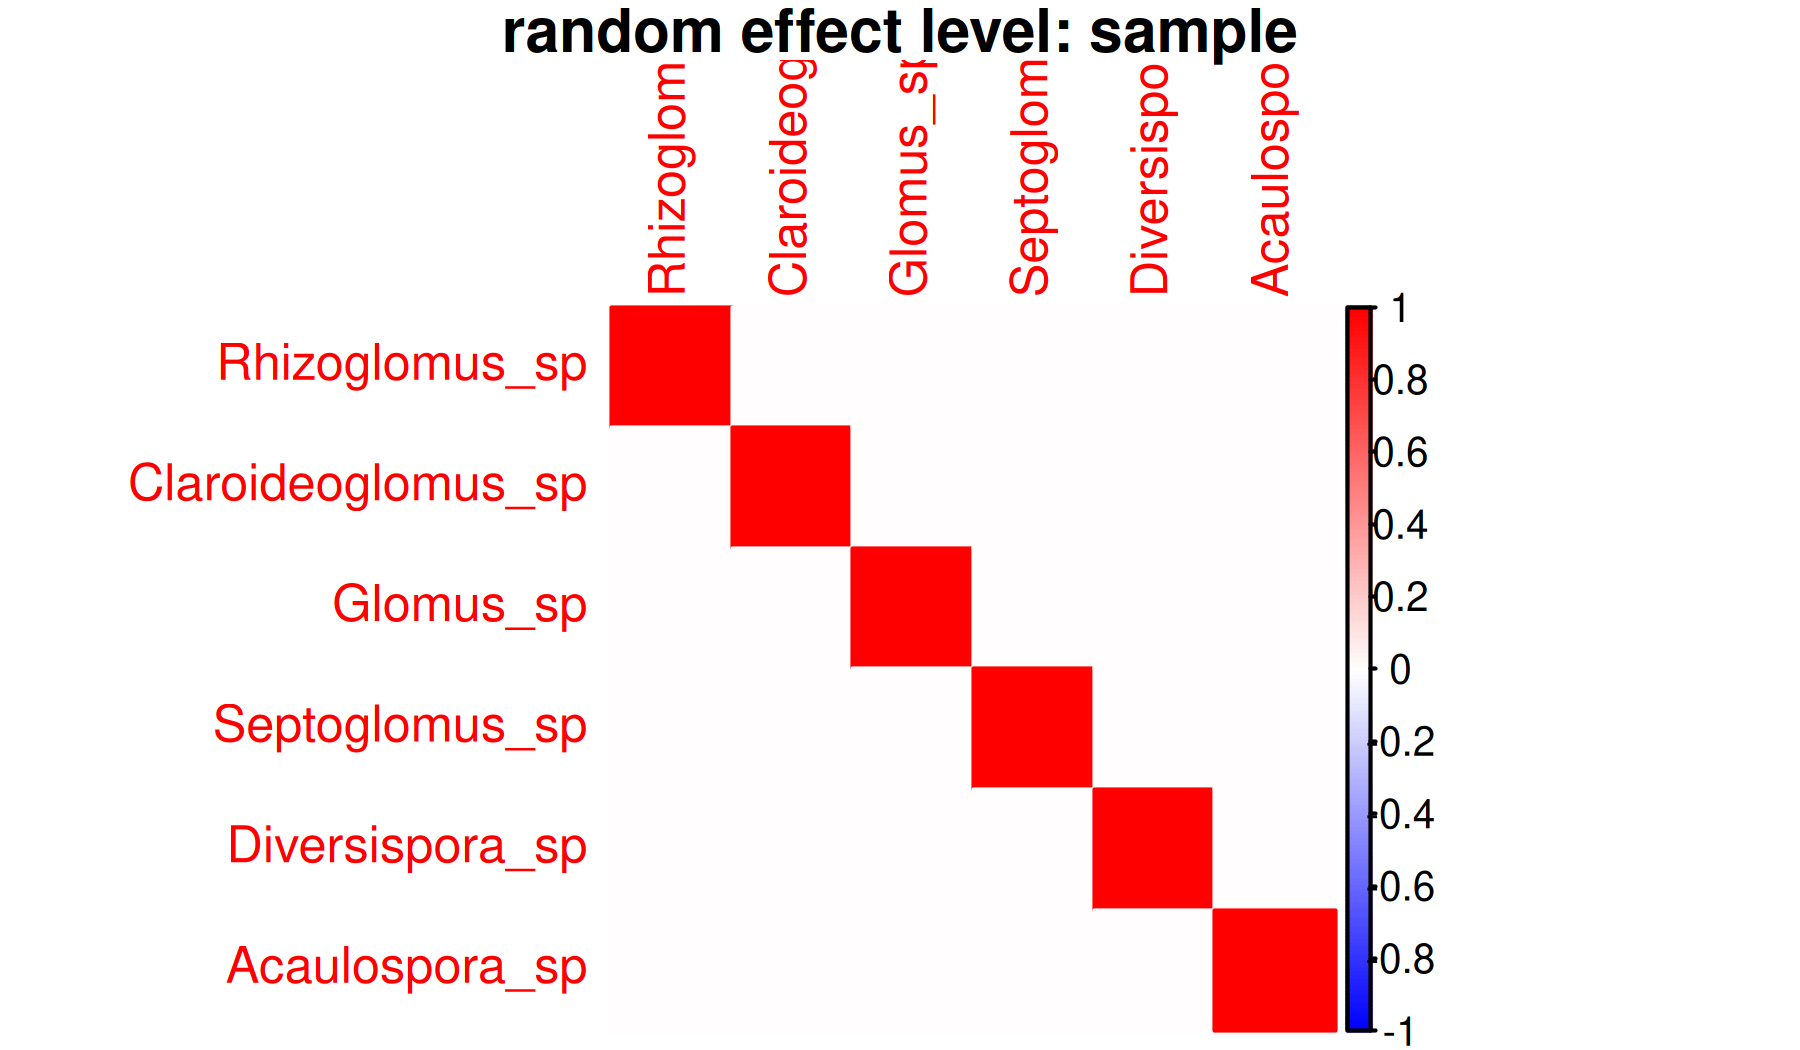

In [17]:
OmegaCor = computeAssociations(m)
supportLevel = 0.9
toPlot = ((OmegaCor[[1]]$support>supportLevel)
+ (OmegaCor[[1]]$support<(1-supportLevel))>0)*OmegaCor[[1]]$mean
corrplot(toPlot, method = "color",
col = colorRampPalette(c("blue","white","red"))(200),
title = paste("random effect level:", m$rLNames[1]), mar=c(0,0,1,0))

In [18]:
preds = computePredictedValues(m)
evaluateModelFit(hM = m, predY = preds)

$RMSE
[1] 0.012063790 0.026509719 0.006130751 0.005748903 0.000948645 0.011121538

$R2
[1] 0.10382478 0.28688803 0.06352559 0.06060768 0.10494663 0.14320814

In [19]:
partition = createPartition(m, nfolds = 2)
preds = computePredictedValues(m, partition = partition, nParallel = 20)
evaluateModelFit(hM = m, predY = preds)

Cross-validation, fold 1 out of 2


using 16 cores for 16 chains



Cross-validation, fold 2 out of 2


using 16 cores for 16 chains



$RMSE
[1] 0.012393481 0.028959776 0.006315169 0.005968302 0.001011758 0.012660730

$R2
[1] 0.0011599174 0.0641259489 0.0065216832 0.0001972718 0.0155867348
[6] 0.0065496361

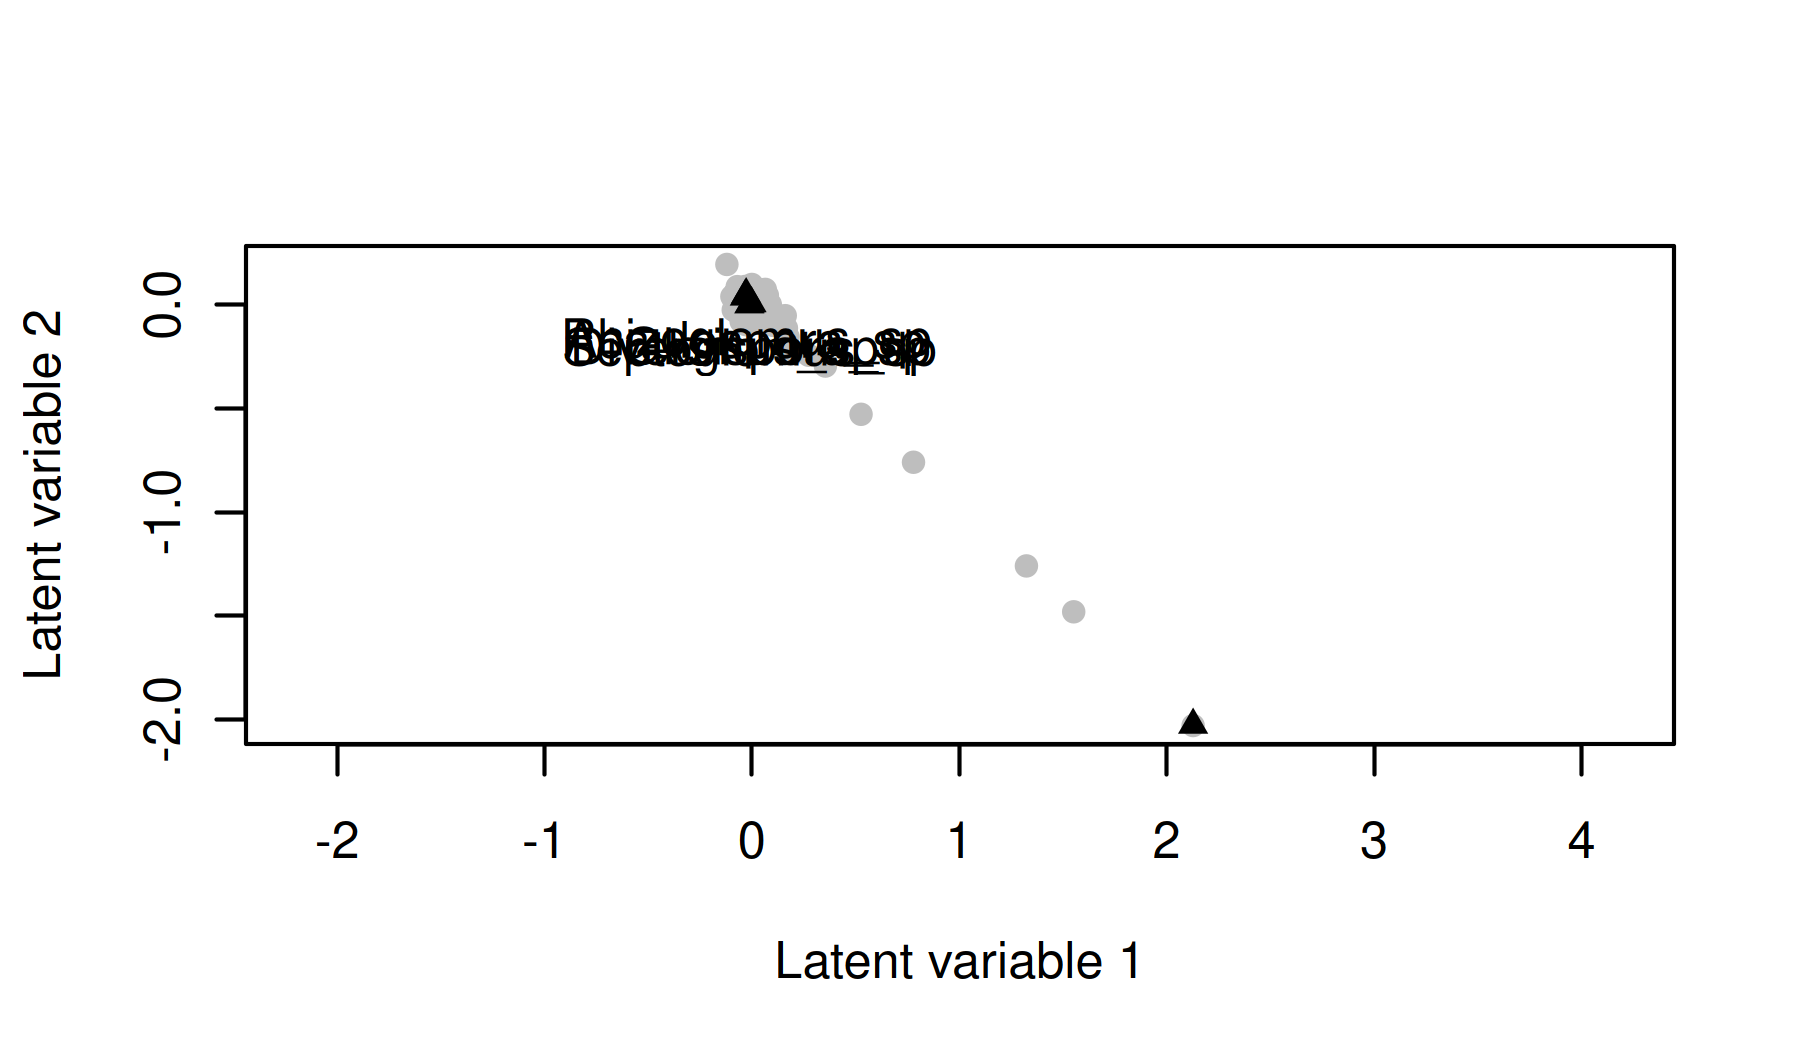

In [20]:
rL <- HmscRandomLevel(units = as.factor(row.names(dataset_wide)))
rL$nfMin=2
rL$nfMax=2
m = Hmsc(
  Y=dataset_wide[species_names],
  XData=dataset_wide[predictors],
  XFormula=~1,
  studyDesign=data.frame(sample = as.factor(row.names(dataset_wide))),
  ranLevels=list(sample=rL)
)
m <- sampleMcmc(
  m,
  thin = 10,
  samples = 100,
  transient = 500,
  nChains = 16,
  nParallel = 16,
  verbose = 1
)

etaPost=getPostEstimate(m, "Eta")
lambdaPost=getPostEstimate(m, "Lambda")
biPlot(m, etaPost = etaPost, lambdaPost = lambdaPost, factors = c(1, 2))

# Kansas Only

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


Species            n  
1  Glomeraceae_spp    951
2  Rhizoglomus_sp     756
3  Claroideoglomus_sp 179
4  Septoglomus_sp     133
5  Glomus_sp          120
6  Diversispora_sp     66
7  Acaulospora_sp      61
8  Funneliformis_sp    31
9  Paraglomus_sp       30
10 Gigaspora_sp        20
11 Ambispora_sp        10
12 Scutellospora_sp    10
13 Archaeospora_sp      3
14 Cetraspora_sp        3

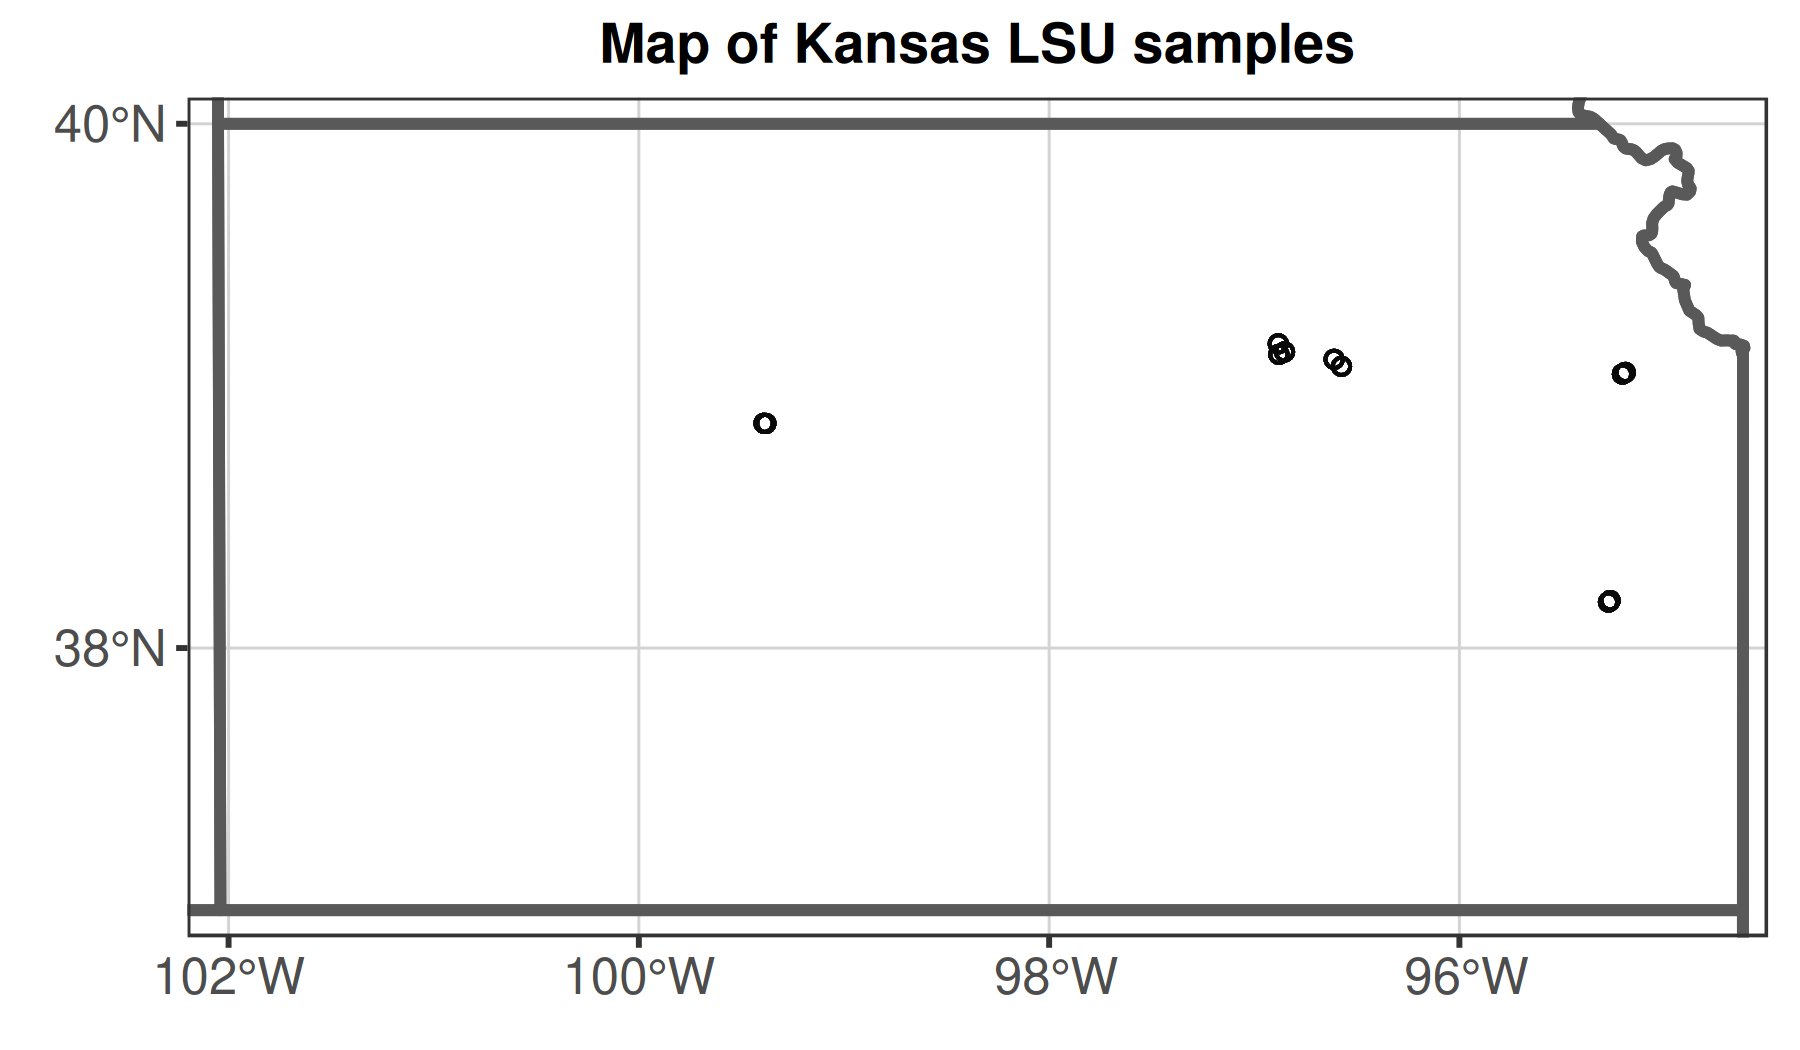

In [10]:
kansas_locations <- st_as_sf(
  collect(tbl(con, "locations")),
  coords = c('longitude', 'latitude'),
  crs = 4326
) |>
  st_crop(
    st_bbox(
      c(xmin = -102.2, xmax = -94.5, ymin = 36.9, ymax = 40.1),
      crs = 4326
    )
  )
USA <- ne_states(country = "united states of america", returnclass = "sf")
p <- ggplot(
) +
  geom_sf(
    data = USA, fill = NA, linewidth = 1, show.legend = FALSE
  ) +
  geom_sf(
    data = kansas_locations,
    shape = 21, color = "black", fill = NA, alpha = 0.05
  ) +
  coord_sf(
    crs = "WGS84", default_crs = "WGS84",
    xlim = c(-102.2, -94.5), ylim = c(36.9, 40.1), expand = FALSE
  ) +
  theme(
    panel.grid = element_line(color = "lightgray", size = 0.25),
  ) +
  scale_x_continuous(breaks = seq(-180, 180, 2)) +
  scale_y_continuous(breaks = seq(-90, 90, 2)) +
  labs(
    x = element_blank(), y = element_blank(),
    title = "Map of Kansas LSU samples"
  )
suppressWarnings(print(p))
count(st_drop_geometry(kansas_locations), Species) |> arrange(desc(n))

Warning message:
“[extract] transforming vector data to the CRS of the raster”


[1] "sample_id"  "taxon_id"   "abundance"  "total"      "Species"   
 [6] "chirps"     "ppt"        "tmax"       "tmean"      "tmin"      
[11] "vpdmax"     "vpdmin"     "aws0_30"    "pwsl1pomu"  "rootznemc" 
[16] "soc0_30"    "droughty"   "proportion"

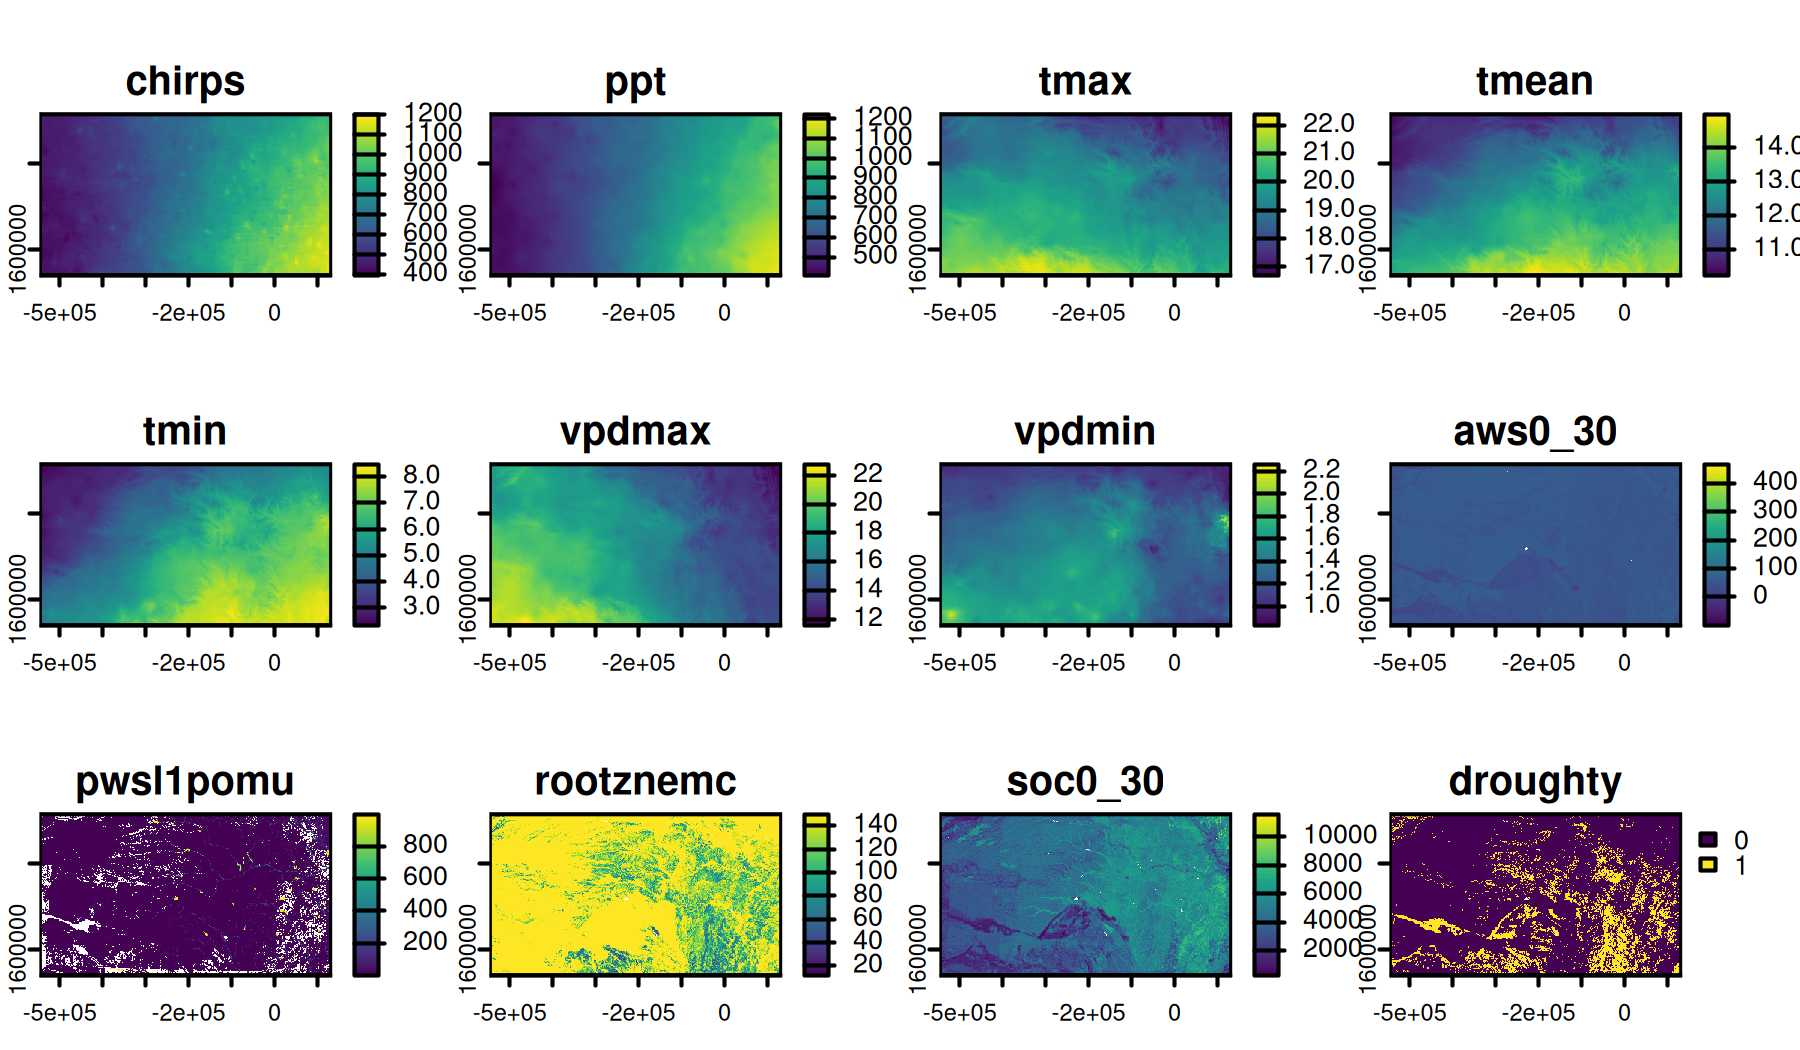

In [11]:
gis_dataset <- rast("../processing/gis/gis_data_1km.nc")
lsu_points <- kansas_locations
kansas_gis_dataset <- crop(
  gis_dataset,
  project(
    ext(c(-102.2, -94.5, 36.9, 40.1)),
    from = "EPSG:4326",
    to = "EPSG:5070"
  )
)
plot(kansas_gis_dataset)
extraction <- extract(kansas_gis_dataset, lsu_points)
dataset <- st_drop_geometry(cbind(lsu_points, extraction[, -1]))
dataset$proportion <- dataset$abundance/dataset$total
colnames(dataset)

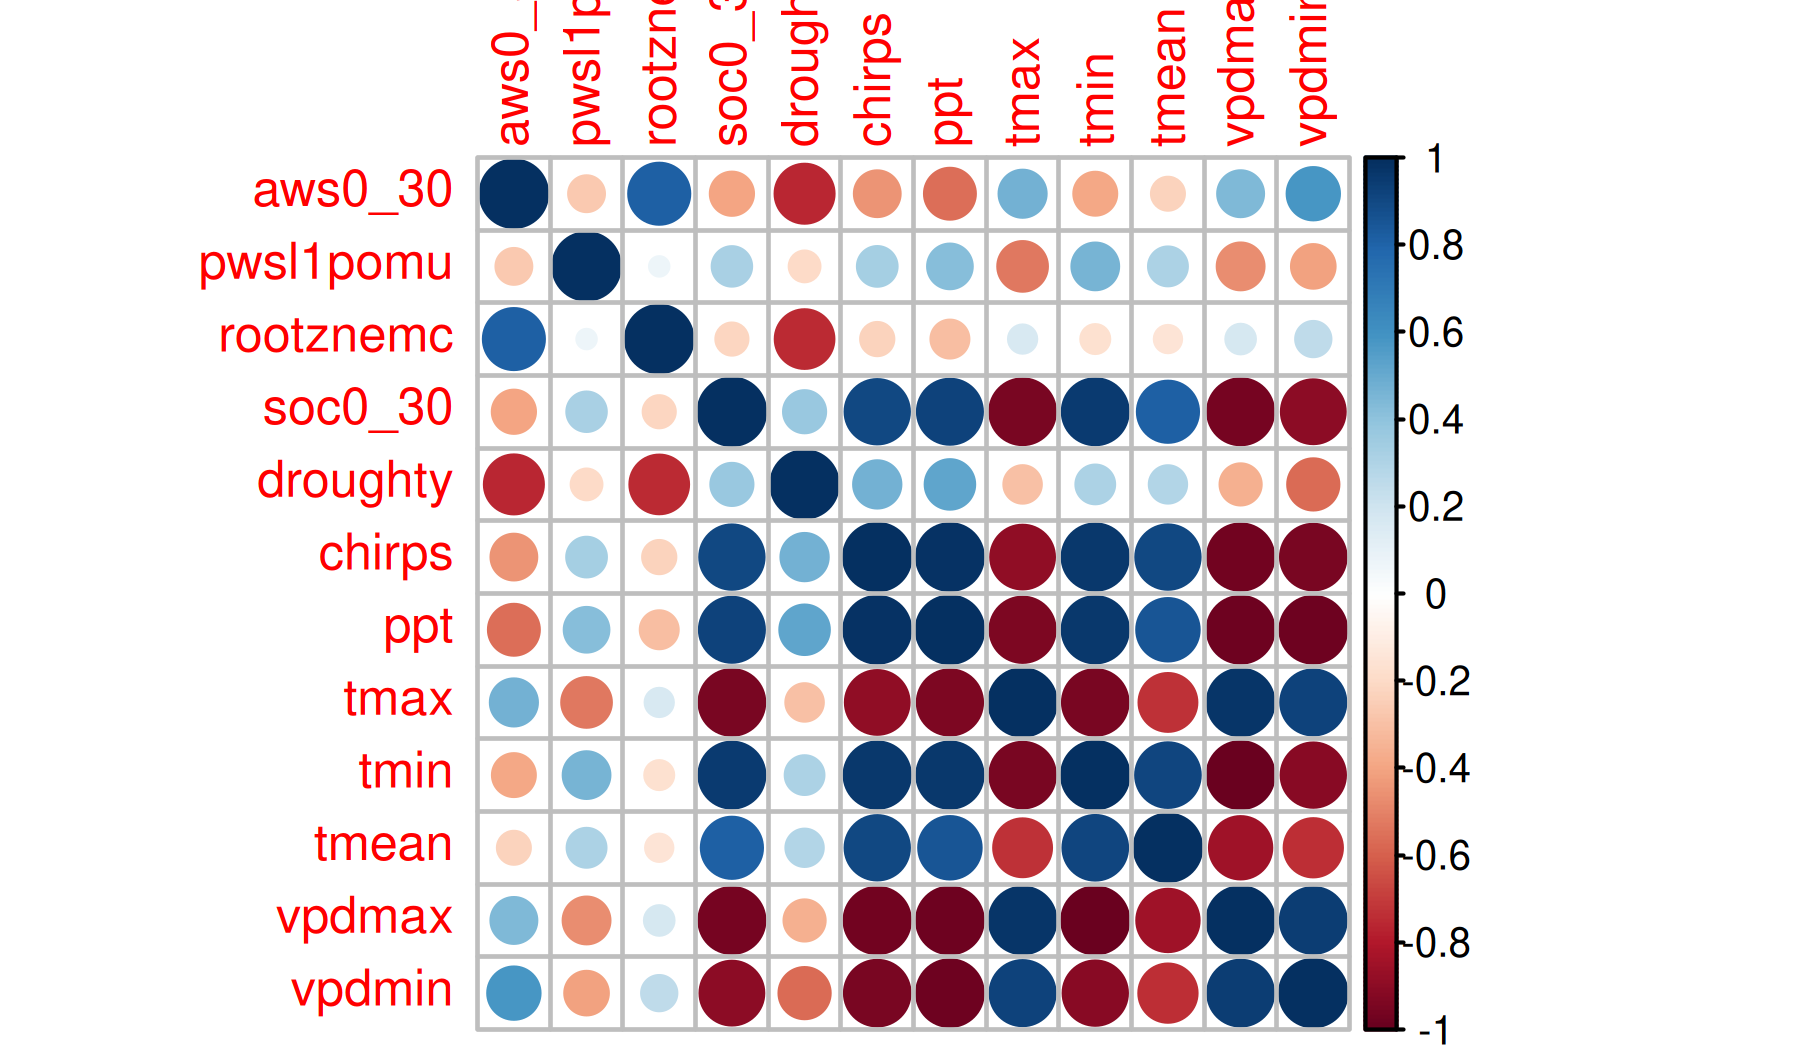

In [12]:
corrplot(cor(dataset[
  ,
  c(
    "aws0_30", # Available water storage estimate, expressed in mm
    "pwsl1pomu", # Potential Wetland Soil Landscapes is expressed as percentage
    "rootznemc", # Root zone depth, expressed in cm
    "soc0_30", # Soil organic carbon stock estimate, grams C per square meter
    "droughty", # “1” for a drought vulnerable soil or “0” for a non-droughty
    "chirps", # Annual Precipitation in 2020 (mm)
    "ppt", # Mean Precip 30 year normal (mm)
    "tmax", # Max Temp 30 year normal (C)
    "tmin", # Min Temp 30 year normal (C)
    "tmean",# Mean Temp 30 year normal (C)
    "vpdmax", # Daily Maximum Vapor Pressure Deficit 30 year normal (hPa)
    "vpdmin" # Daily Minimum Vapor Pressure Deficit 30 year normal (hPa)
  )
], use = "complete.obs"), method = "circle", type = "full")

In [13]:
species_names <- c(
  "Rhizoglomus_sp", "Claroideoglomus_sp", "Septoglomus_sp",
  "Glomus_sp", "Diversispora_sp", "Acaulospora_sp"
)
# pwsl1pomu Removed due to NAs
predictors <- c(
  "aws0_30", # Available water storage estimate, expressed in mm
  "rootznemc", # Root zone depth, expressed in cm
  "soc0_30", # Soil organic carbon stock estimate, grams C per square meter
  "droughty", # “1” for a drought vulnerable soil or “0” for a non-droughty
  "chirps", # Annual Precipitation in 2020 (mm)
  "tmax", # Max Temp 30 year normal (C)
  "tmin", # Min Temp 30 year normal (C)
  "tmean",# Mean Temp 30 year normal (C)
  "vpdmax", # Daily Maximum Vapor Pressure Deficit 30 year normal (hPa)
  "vpdmin" # Daily Minimum Vapor Pressure Deficit 30 year normal (hPa)
)
dataset_wide <- pivot_wider(
  dataset[dataset$Species %in% species_names, ],
  names_from = Species, values_from = proportion
)

m <- Hmsc(
  Y = dataset_wide[species_names],
  XData = dataset_wide[predictors],
  XFormula = ~
    aws0_30 +
    # pwsl1pomu +
    rootznemc +
    soc0_30 +
    # droughty +
    tmax +
    # tmin +
    # tmean +
    vpdmax +
    # vpdmin +
    chirps,
  studyDesign = data.frame(sample = as.factor(row.names(dataset_wide))),
  ranLevels = list(
    sample = HmscRandomLevel(units = as.factor(row.names(dataset_wide)))
  )
)
m <- sampleMcmc(
  m,
  thin = 10,
  samples = 100,
  transient = 500,
  nChains = 16,
  nParallel = 16,
  verbose = 1
)


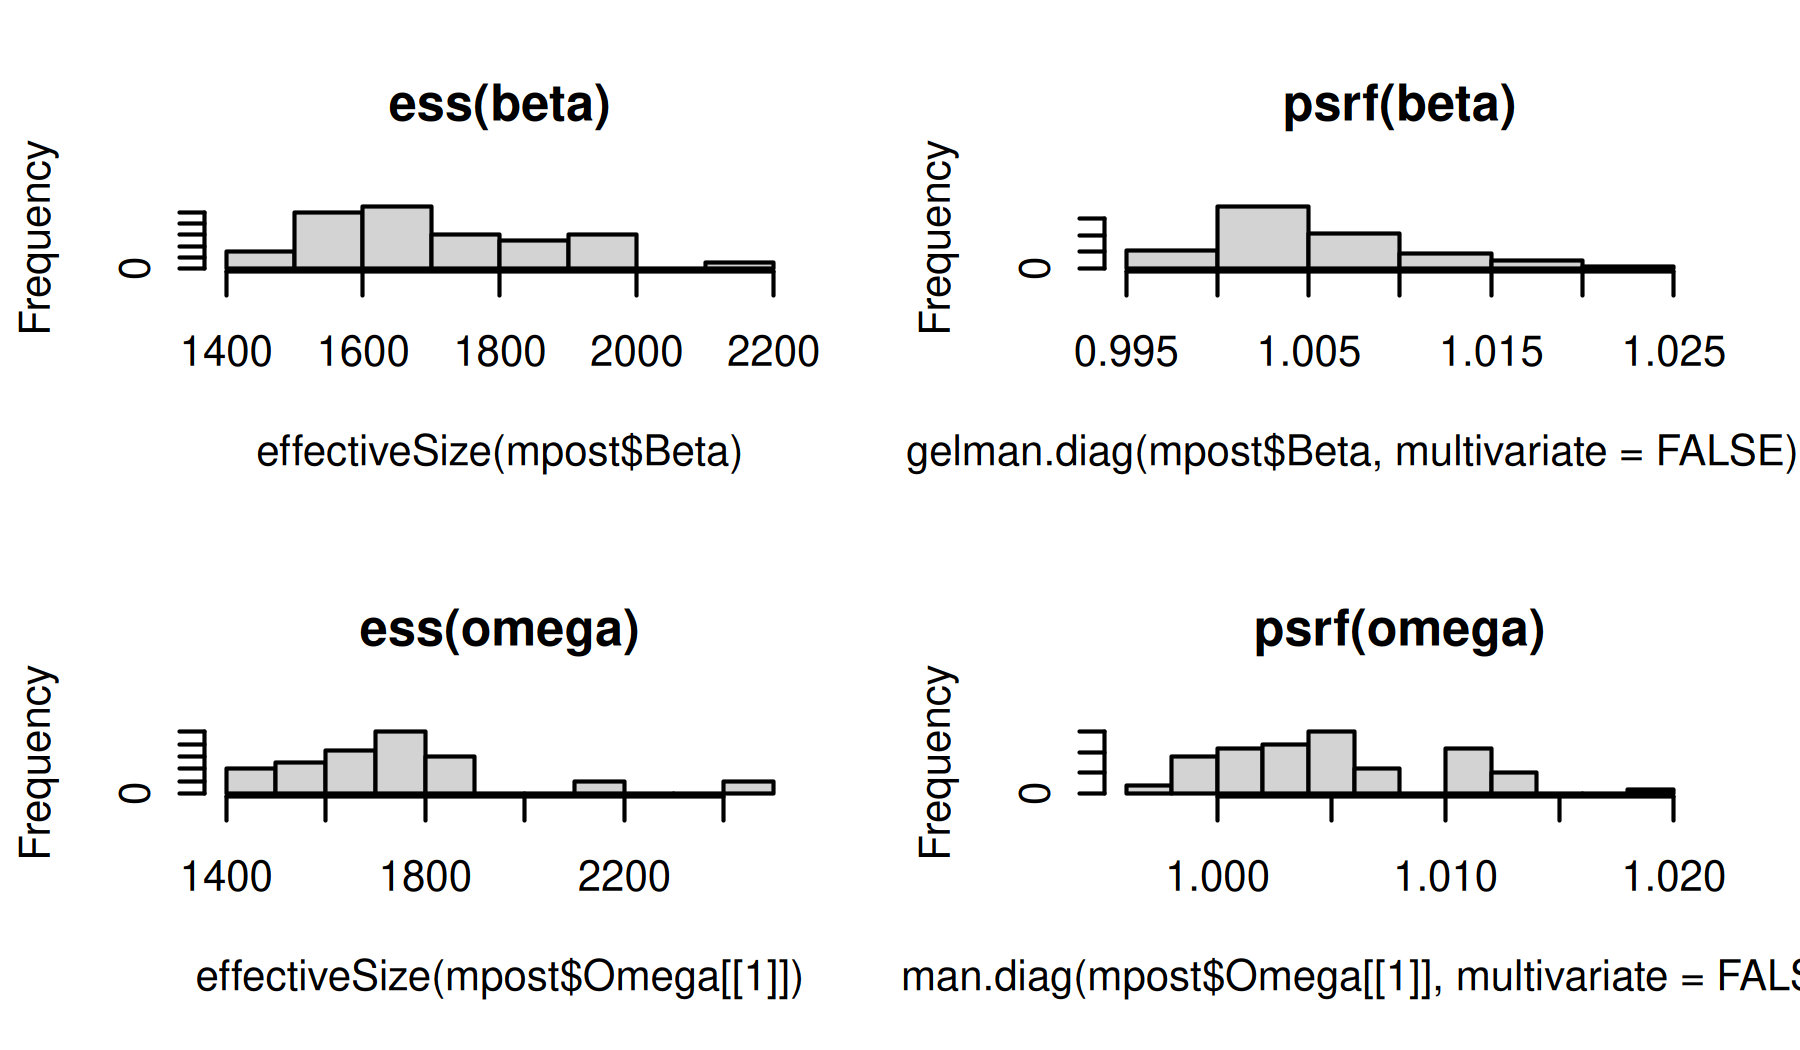

In [27]:
mpost = convertToCodaObject(m)
par(mfrow=c(2,2))
hist(effectiveSize(mpost$Beta), main="ess(beta)")
hist(gelman.diag(mpost$Beta, multivariate=FALSE)$psrf, main="psrf(beta)")
hist(effectiveSize(mpost$Omega[[1]]), main="ess(omega)")
hist(gelman.diag(mpost$Omega[[1]], multivariate=FALSE)$psrf, main="psrf(omega)")

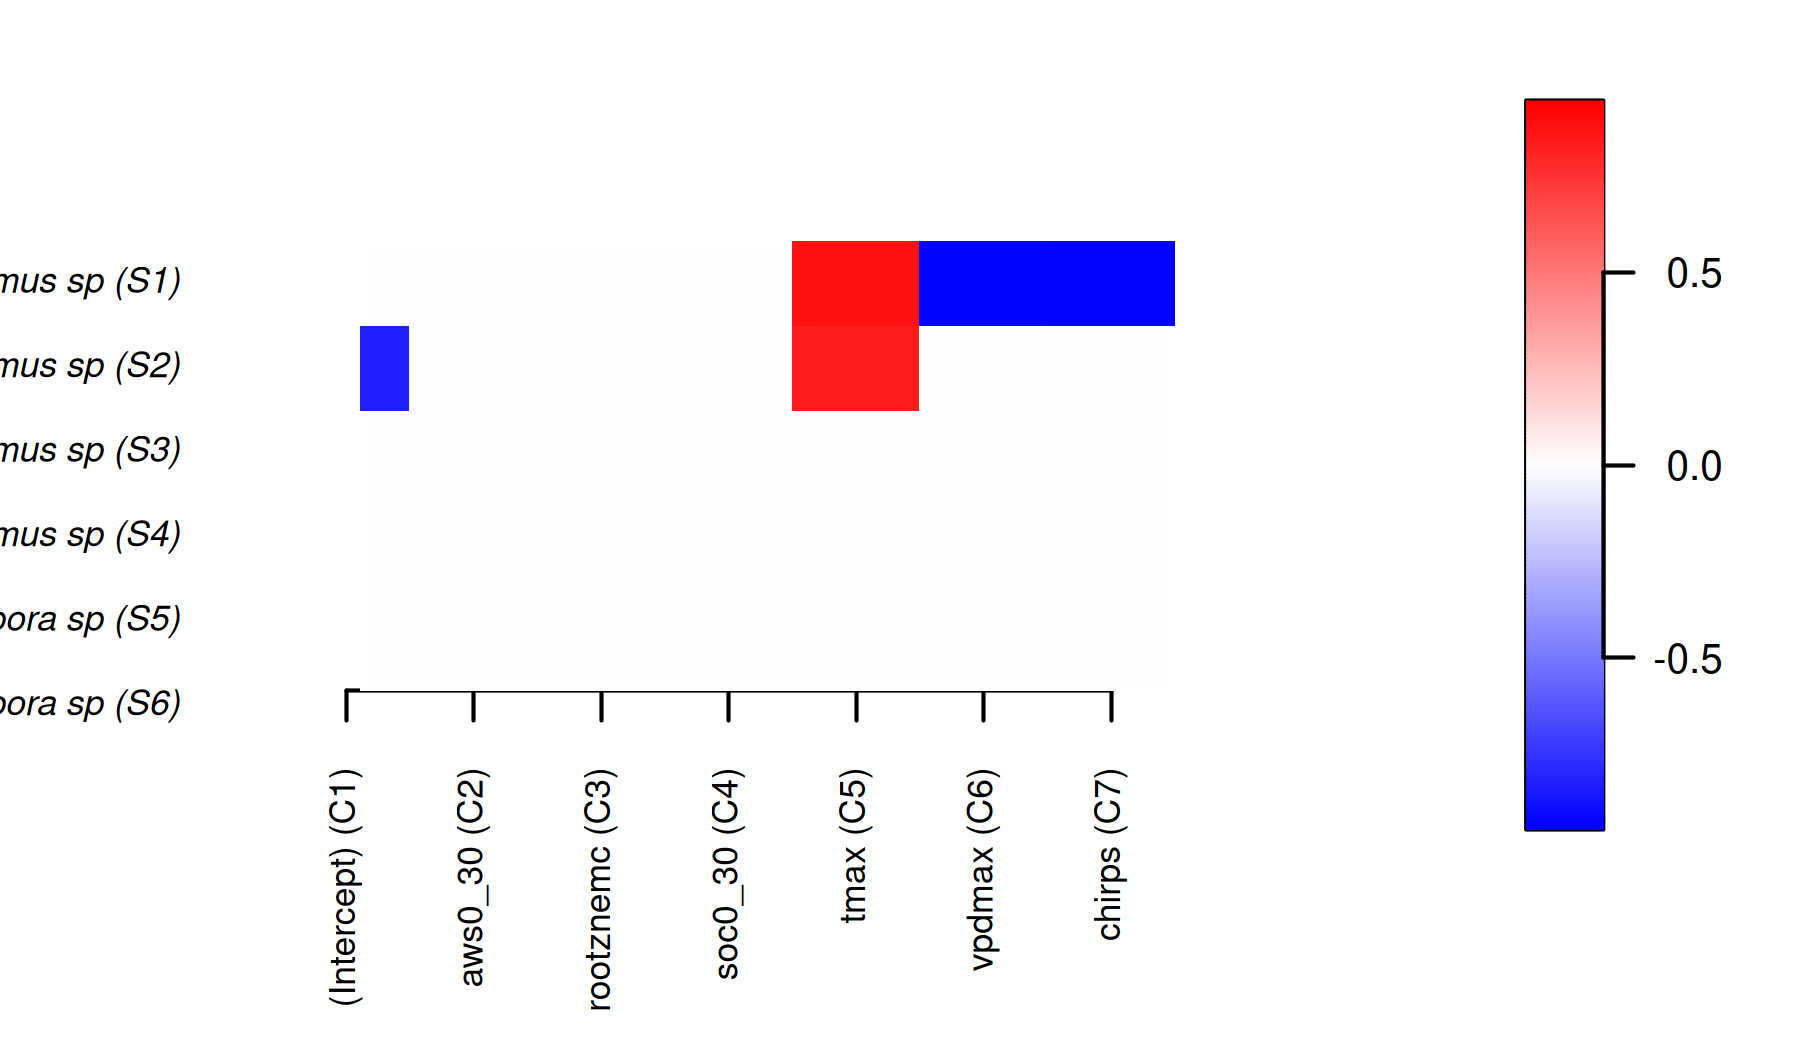

In [29]:
postBeta = getPostEstimate(m, parName="Beta")
plotBeta(m, post=postBeta, param="Support", supportLevel = 0.9)

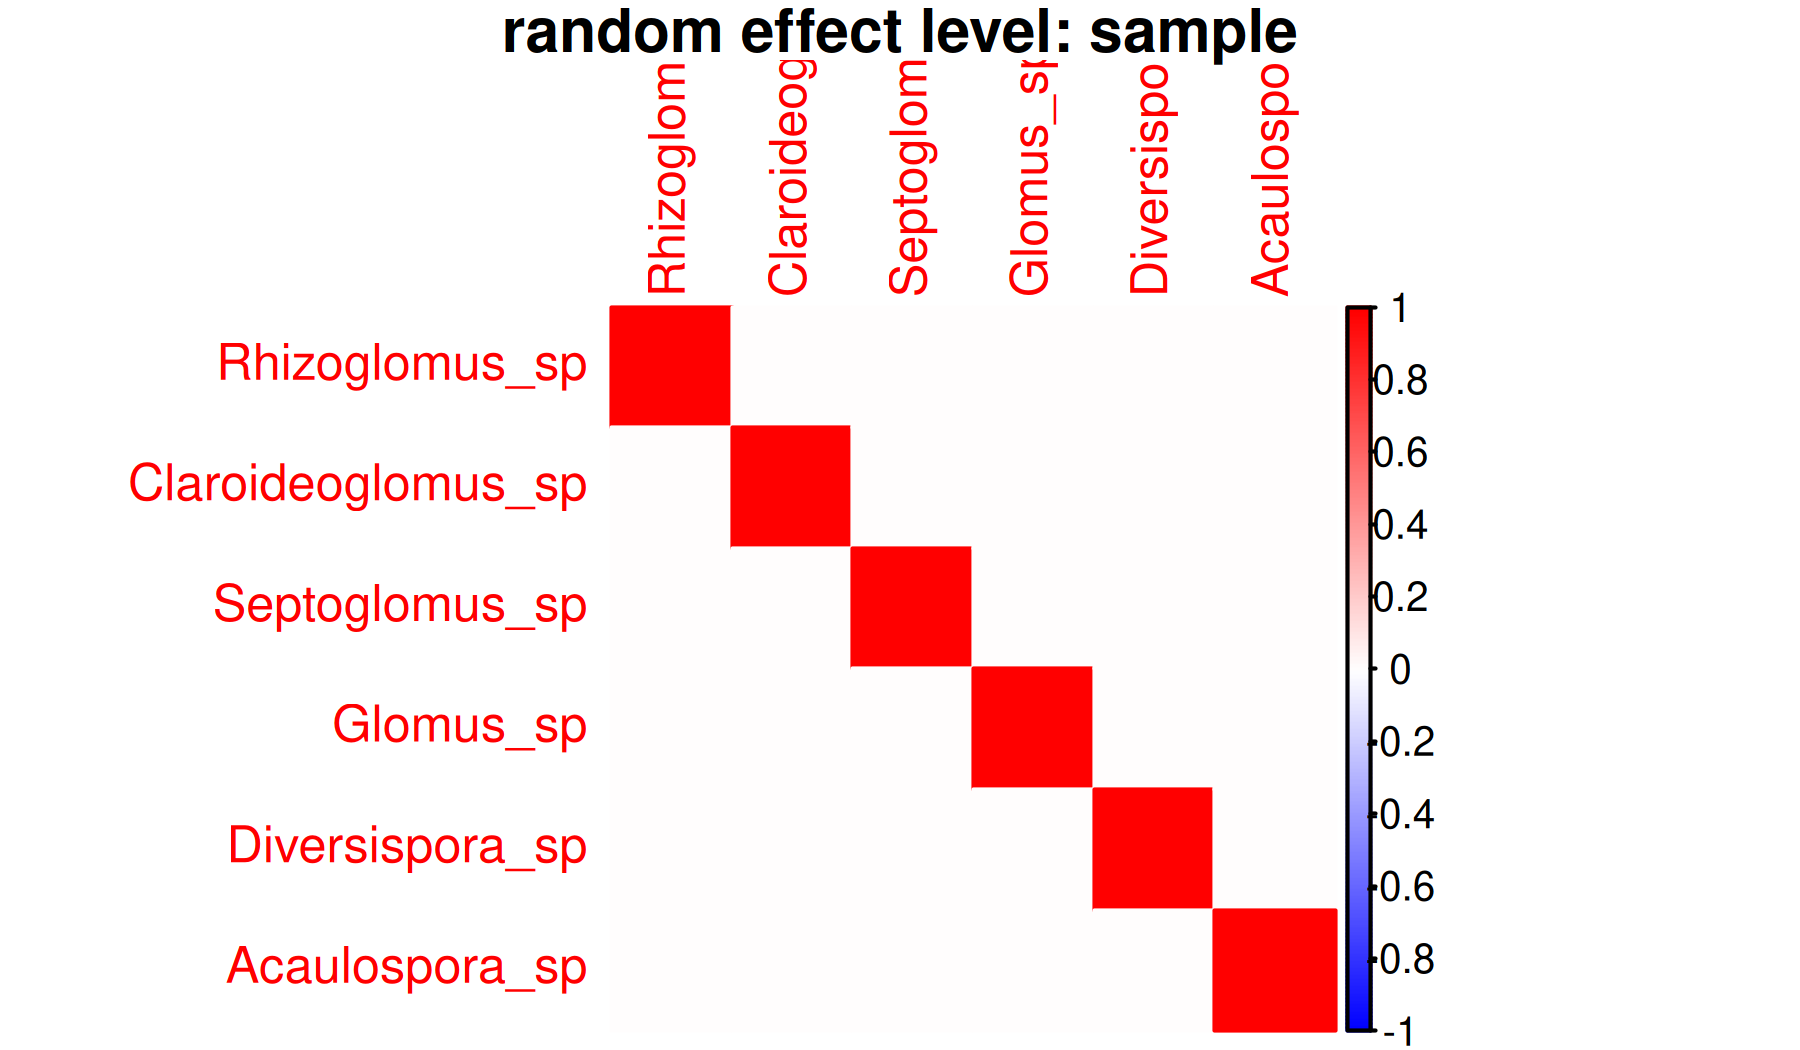

In [31]:
OmegaCor = computeAssociations(m)
supportLevel = 0.9
toPlot = ((OmegaCor[[1]]$support>supportLevel)
+ (OmegaCor[[1]]$support<(1-supportLevel))>0)*OmegaCor[[1]]$mean
corrplot(toPlot, method = "color",
col = colorRampPalette(c("blue","white","red"))(200),
title = paste("random effect level:", m$rLNames[1]), mar=c(0,0,1,0))

In [32]:
preds = computePredictedValues(m)
evaluateModelFit(hM = m, predY = preds)

$RMSE
[1] 0.0085080908 0.0058758392 0.0038261768 0.0024858423 0.0007732019
[6] 0.0051115621

$R2
[1] 0.0585750 0.1190127 0.1066953 0.1583425 0.1110041 0.1851310

In [33]:
partition = createPartition(m, nfolds = 2)
preds = computePredictedValues(m, partition = partition, nParallel = 8)
evaluateModelFit(hM = m, predY = preds)

Cross-validation, fold 1 out of 2
Cross-validation, fold 2 out of 2


$RMSE
[1] 0.0087578805 0.0065846393 0.0041196822 0.0028750466 0.0009306606
[6] 0.0068322545

$R2
[1]  0.0002848983  0.0005287443 -0.0008713395  0.0184751824  0.0129951029
[6] -0.0024329854

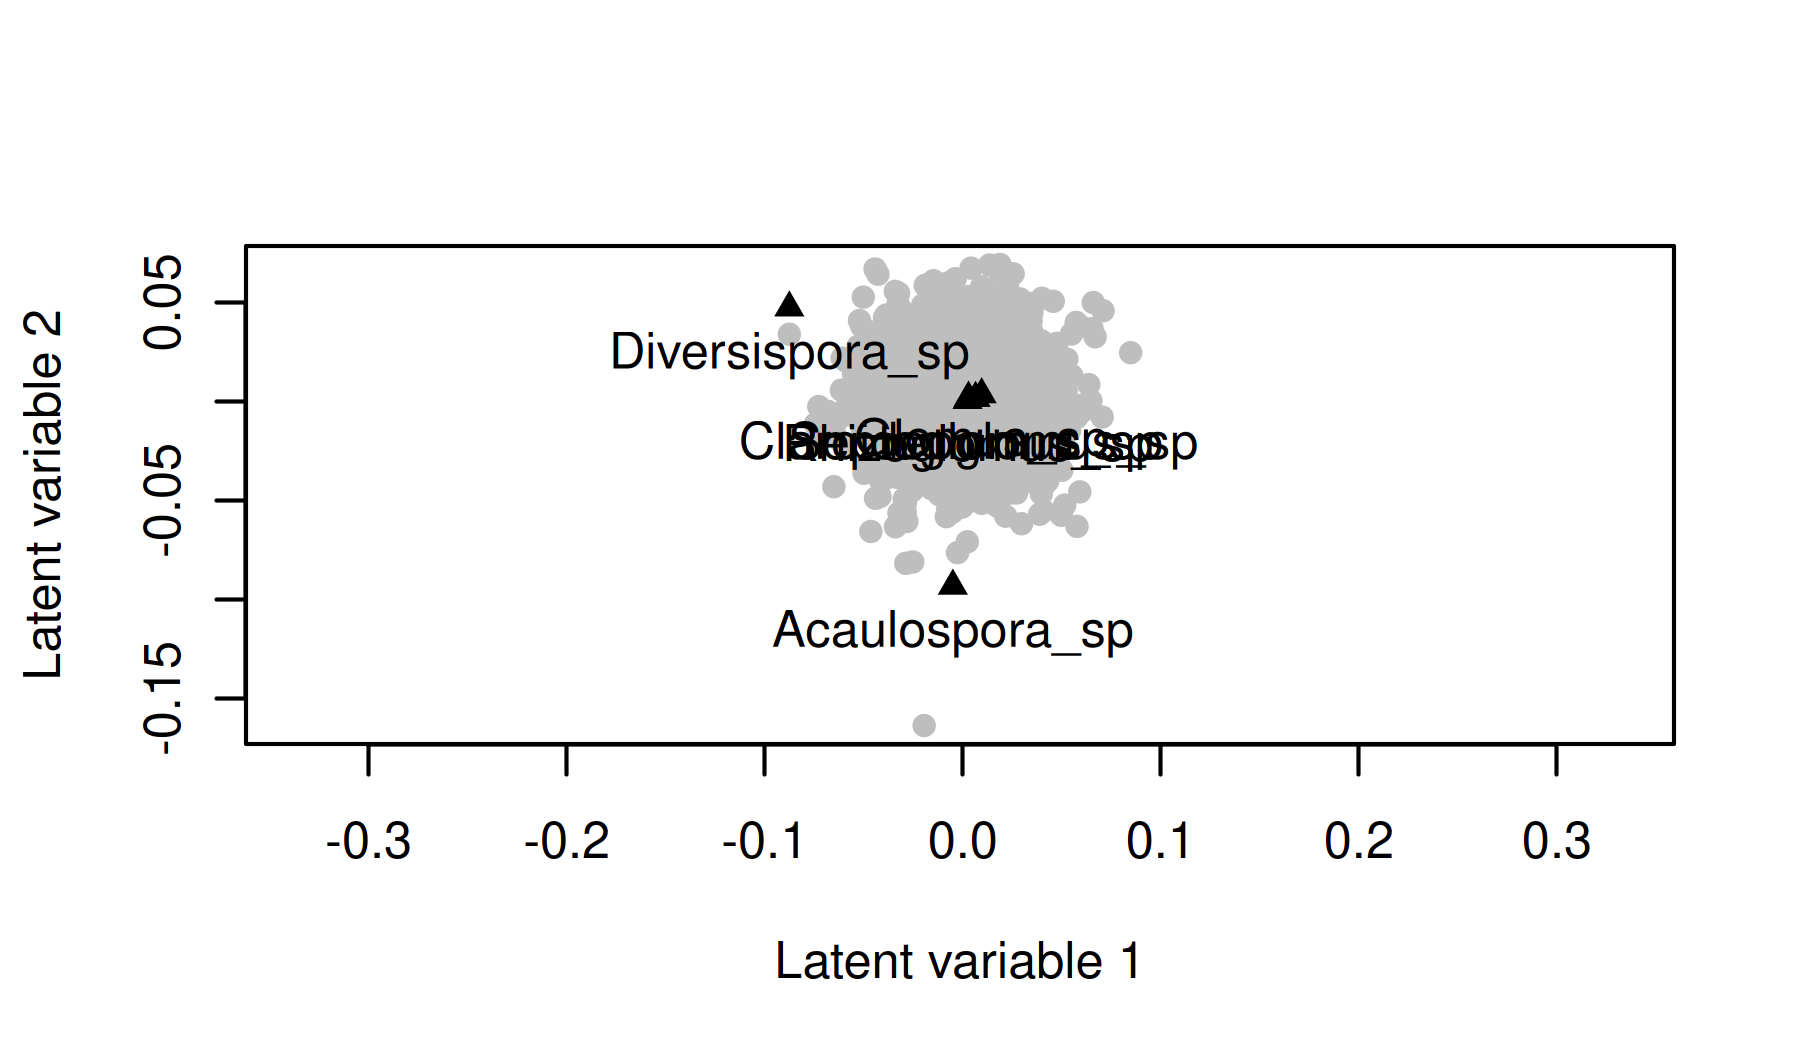

In [35]:
rL <- HmscRandomLevel(units = as.factor(row.names(dataset_wide)))
rL$nfMin=2
rL$nfMax=2
m = Hmsc(
  Y=dataset_wide[species_names],
  XData=dataset_wide[predictors],
  XFormula=~1,
  studyDesign=data.frame(sample = as.factor(row.names(dataset_wide))),
  ranLevels=list(sample=rL)
)
m <- sampleMcmc(
  m,
  thin = 10,
  samples = 100,
  transient = 500,
  nChains = 16,
  nParallel = 16,
  verbose = 1
)

etaPost=getPostEstimate(m, "Eta")
lambdaPost=getPostEstimate(m, "Lambda")
biPlot(m, etaPost = etaPost, lambdaPost = lambdaPost, factors = c(1, 2))

## Regressions

In [ ]:
# distr = c("normal","probit","poisson","lognormal poisson")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



Call:
glm(formula = proportion ~ aws0_30 + rootznemc + soc0_30 + chirps, 
    family = gaussian(link = "log"), data = dataset[dataset$Species == 
        species, ])

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.1351234  1.7206432  -1.241  0.21504    
aws0_30     -0.2520747  0.0509540  -4.947 9.30e-07 ***
rootznemc    0.1023825  0.0255911   4.001 6.94e-05 ***
soc0_30      0.0003558  0.0001850   1.923  0.05485 .  
chirps      -0.0049659  0.0017212  -2.885  0.00403 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 7.478509e-05)

    Null deviance: 0.057107  on 755  degrees of freedom
Residual deviance: 0.056148  on 751  degrees of freedom
AIC: -5030.5

Number of Fisher Scoring iterations: 10



Warning message:
“glm.fit: algorithm did not converge”


Analysis of Deviance Table (Type II tests)

Response: proportion
          LR Chisq Df Pr(>Chisq)    
aws0_30    11.7694  1  0.0006021 ***
rootznemc  12.0858  1  0.0005081 ***
soc0_30     4.5956  1  0.0320546 *  
chirps      6.8495  1  0.0088666 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


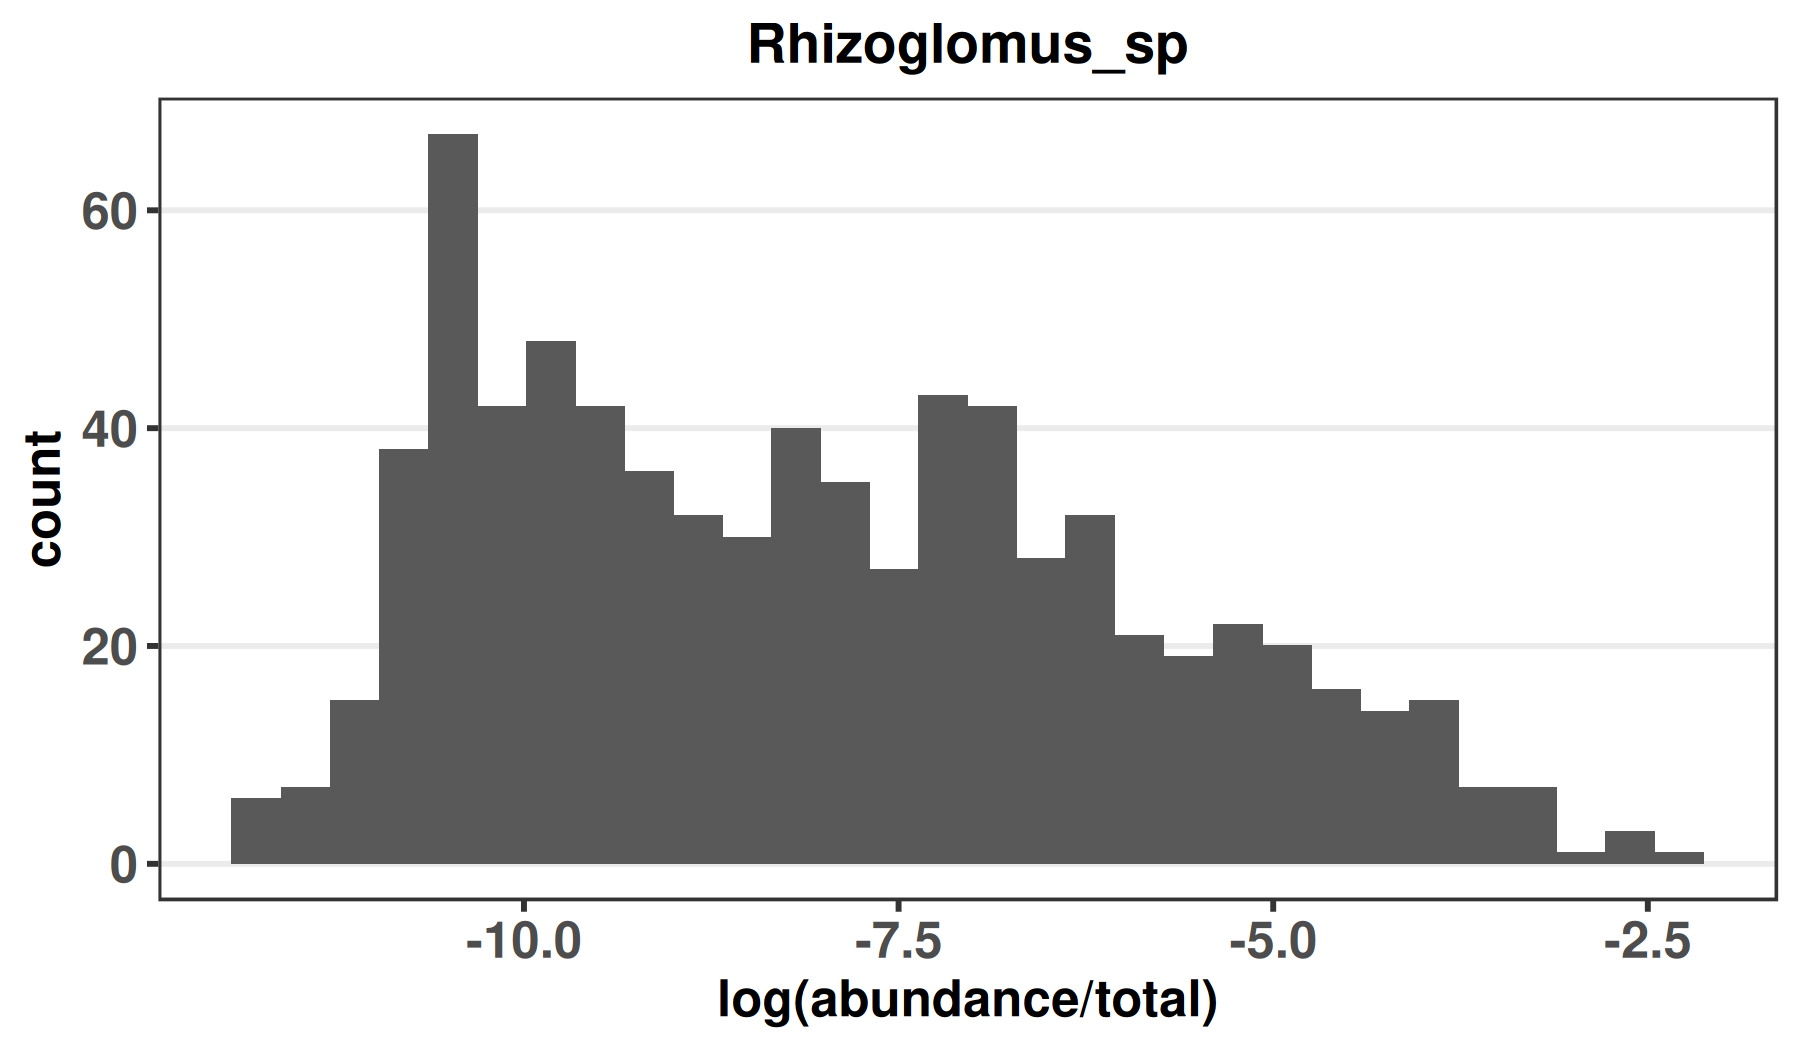

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


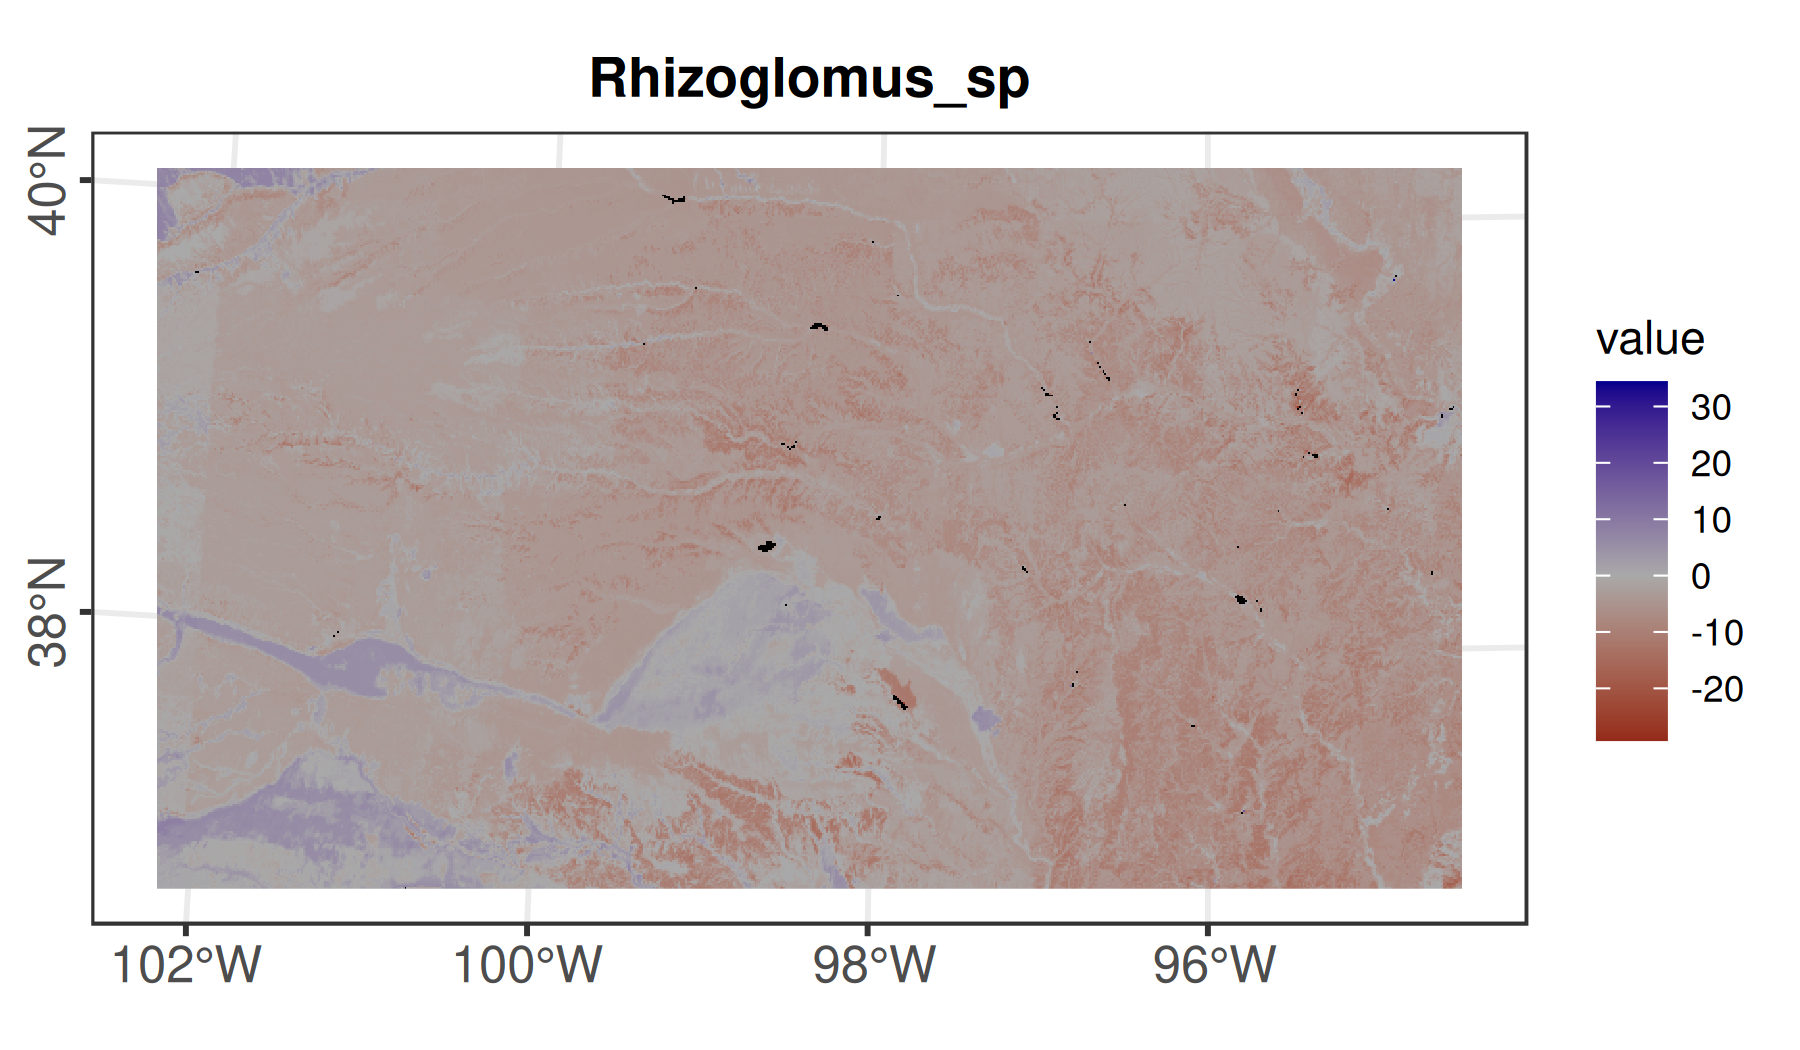


Call:
glm(formula = proportion ~ aws0_30 + rootznemc + soc0_30 + chirps, 
    family = gaussian(link = "log"), data = dataset[dataset$Species == 
        species, ])

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept) -1.564e+02  9.471e+01  -1.651   0.1006  
aws0_30      3.151e+00  2.071e+00   1.522   0.1299  
rootznemc   -4.537e-01  3.234e-01  -1.403   0.1624  
soc0_30     -1.399e-02  8.387e-03  -1.668   0.0971 .
chirps       1.186e-01  6.909e-02   1.717   0.0877 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 3.668918e-05)

    Null deviance: 0.0069672  on 178  degrees of freedom
Residual deviance: 0.0063459  on 174  degrees of freedom
AIC: -1314.3

Number of Fisher Scoring iterations: 12

Analysis of Deviance Table (Type II tests)

Response: proportion
          LR Chisq Df Pr(>Chisq)    
aws0_30     1.3183  1  0.2509025    
rootznemc   1.2848  1  0.2569992    
soc0_30     1.3495

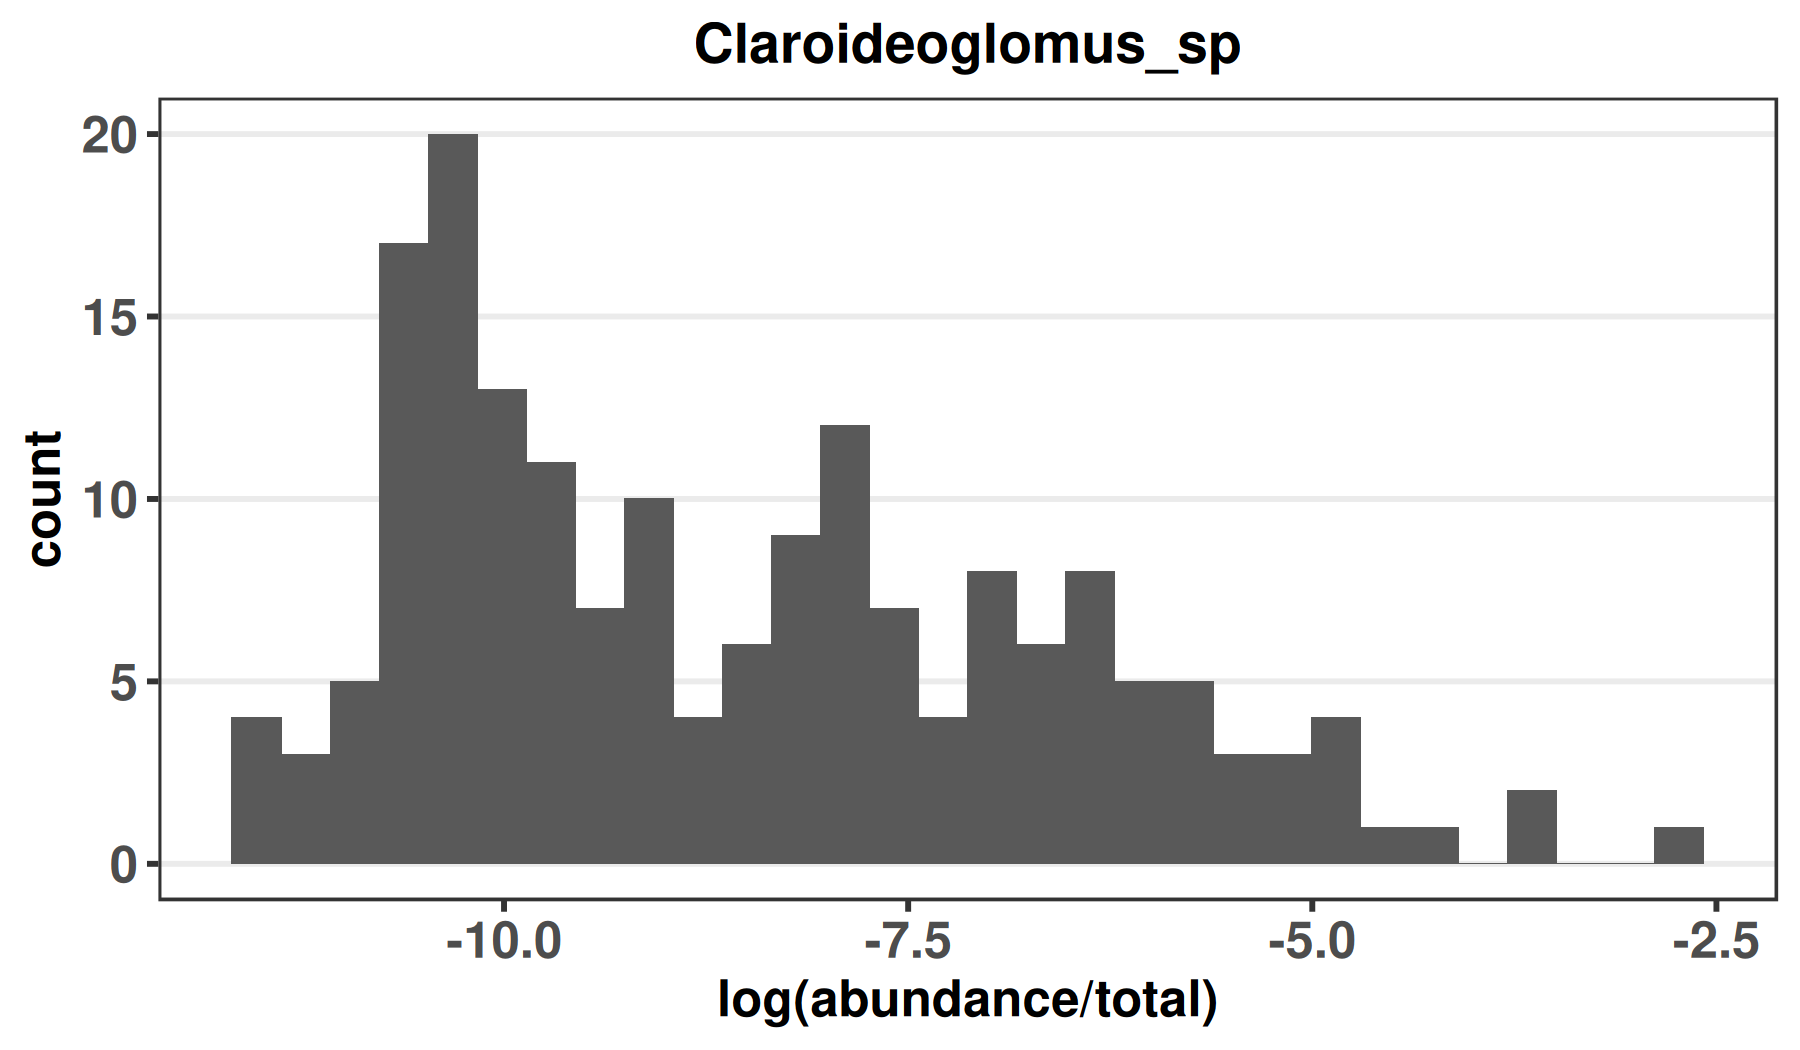

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


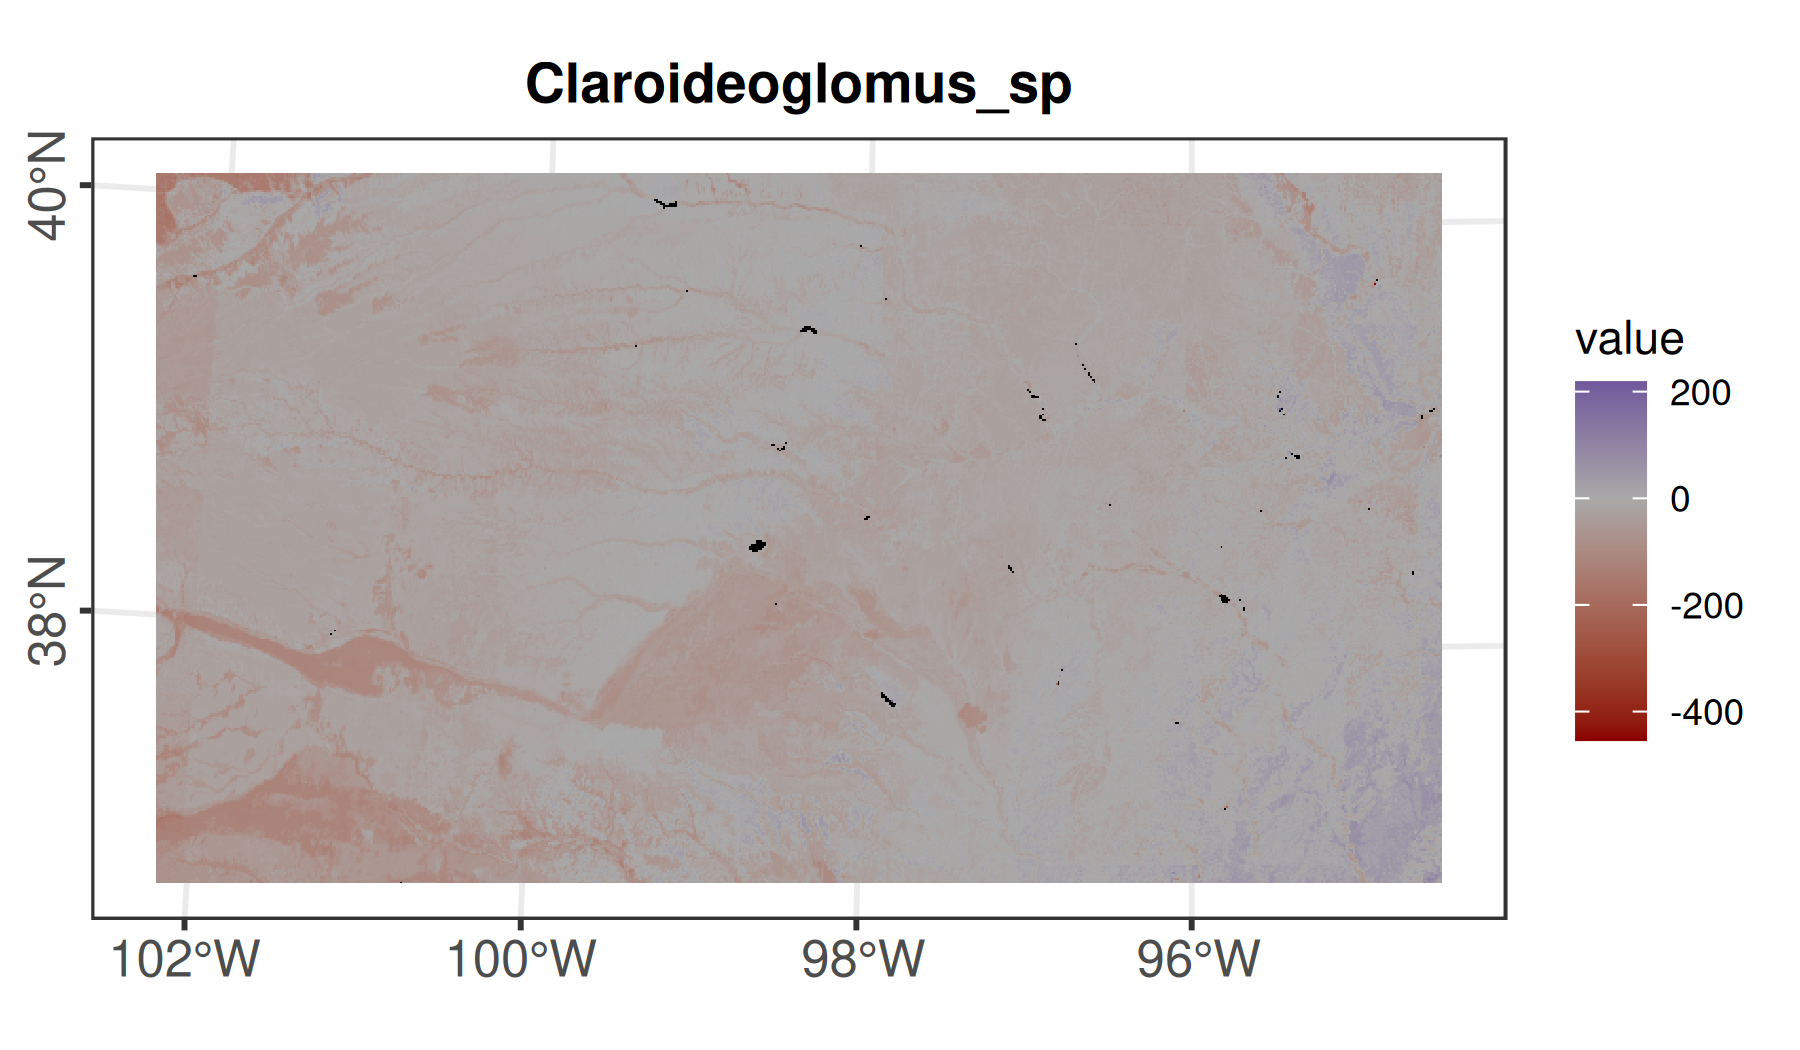


Call:
glm(formula = proportion ~ aws0_30 + rootznemc + soc0_30 + chirps, 
    family = gaussian(link = "log"), data = dataset[dataset$Species == 
        species, ])

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -6.9231509  4.4384550  -1.560    0.121
aws0_30      0.0008249  0.0828096   0.010    0.992
rootznemc   -0.0055753  0.0214918  -0.259    0.796
soc0_30      0.0004461  0.0003106   1.436    0.153
chirps      -0.0017219  0.0034349  -0.501    0.617

(Dispersion parameter for gaussian family taken to be 1.636863e-05)

    Null deviance: 0.0021446  on 132  degrees of freedom
Residual deviance: 0.0020952  on 128  degrees of freedom
AIC: -1081.3

Number of Fisher Scoring iterations: 10

Analysis of Deviance Table (Type II tests)

Response: proportion
          LR Chisq Df Pr(>Chisq)
aws0_30    0.00013  1     0.9910
rootznemc  0.08053  1     0.7766
soc0_30    2.06235  1     0.1510
chirps     0.23136  1     0.6305


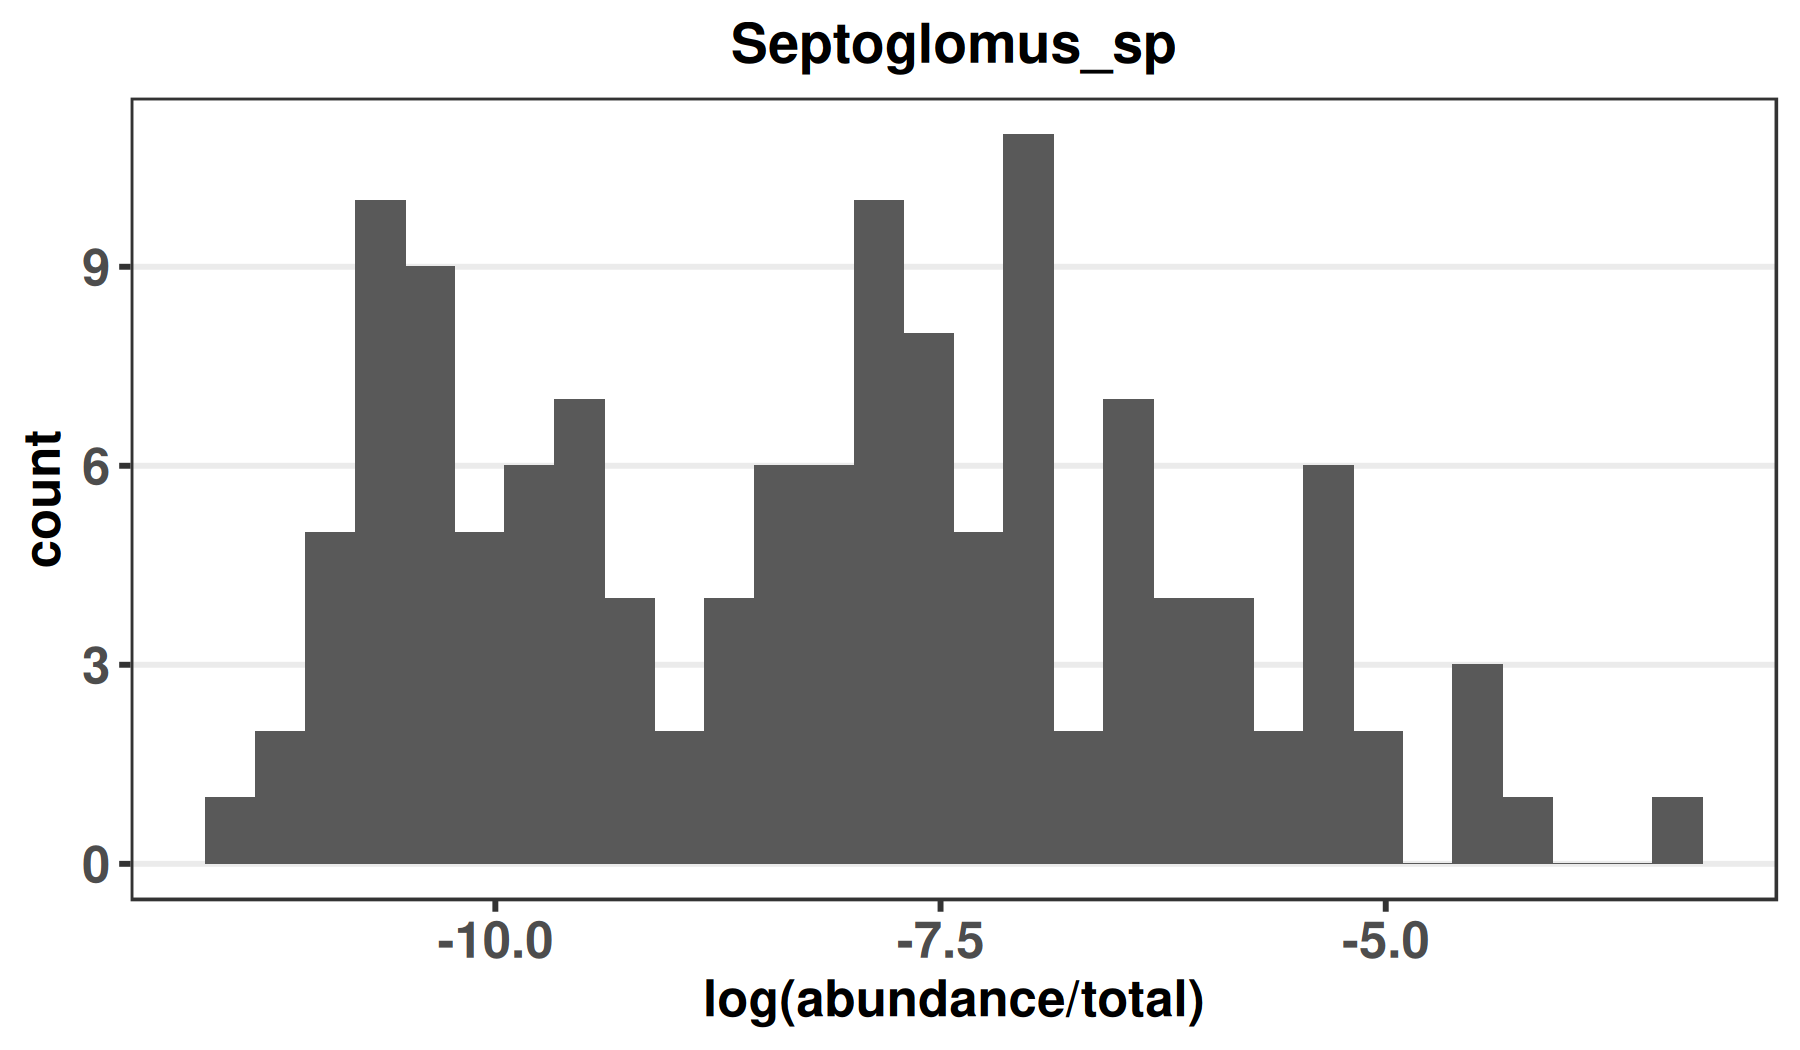

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


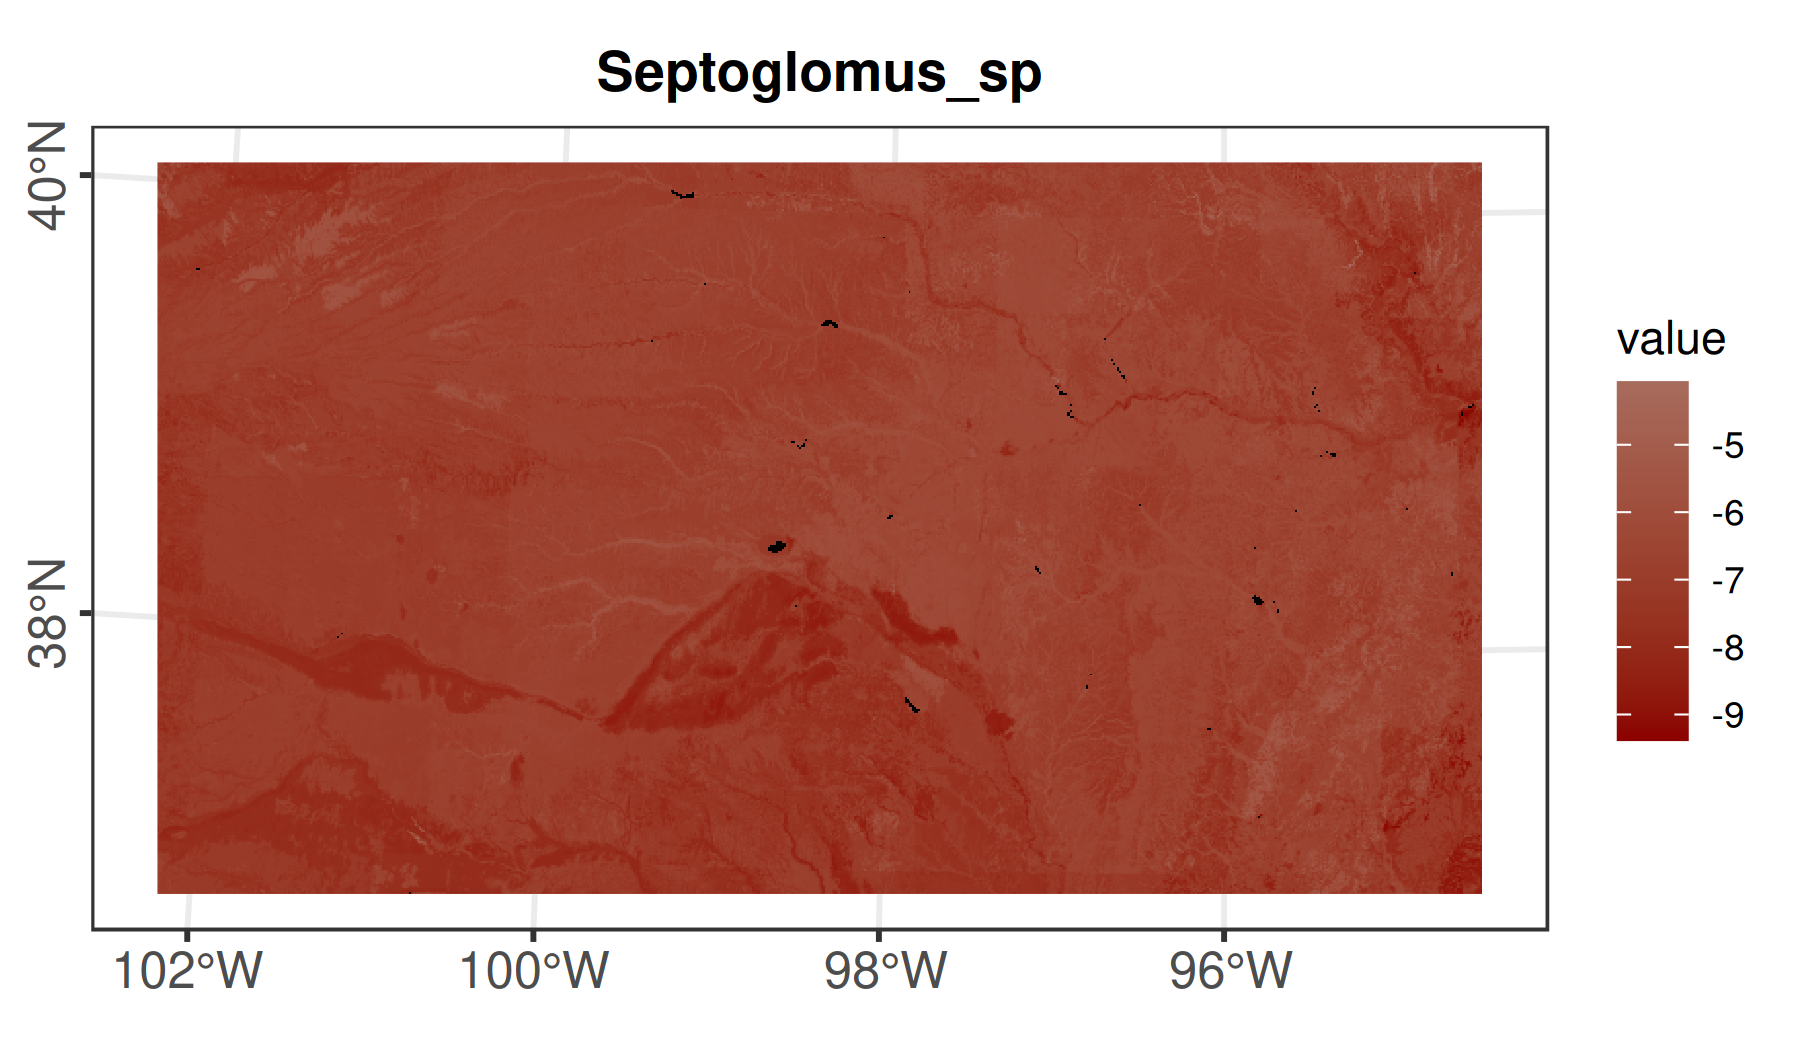


Call:
glm(formula = proportion ~ aws0_30 + rootznemc + soc0_30 + chirps, 
    family = gaussian(link = "log"), data = dataset[dataset$Species == 
        species, ])

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) 10.8966923 10.6921333   1.019    0.310
aws0_30     -0.2635385  0.1879048  -1.403    0.163
rootznemc    0.0093131  0.0272501   0.342    0.733
soc0_30     -0.0007612  0.0005176  -1.471    0.144
chirps      -0.0015304  0.0031992  -0.478    0.633

(Dispersion parameter for gaussian family taken to be 6.665653e-06)

    Null deviance: 0.00087796  on 119  degrees of freedom
Residual deviance: 0.00076578  on 115  degrees of freedom
AIC: -1082.9

Number of Fisher Scoring iterations: 8

Analysis of Deviance Table (Type II tests)

Response: proportion
          LR Chisq Df Pr(>Chisq)  
aws0_30     5.1890  1    0.02273 *
rootznemc   0.1964  1    0.65762  
soc0_30     3.7169  1    0.05386 .
chirps      0.2667  1    0.60558  
---
Signif. codes:  0 ‘***’ 0.00

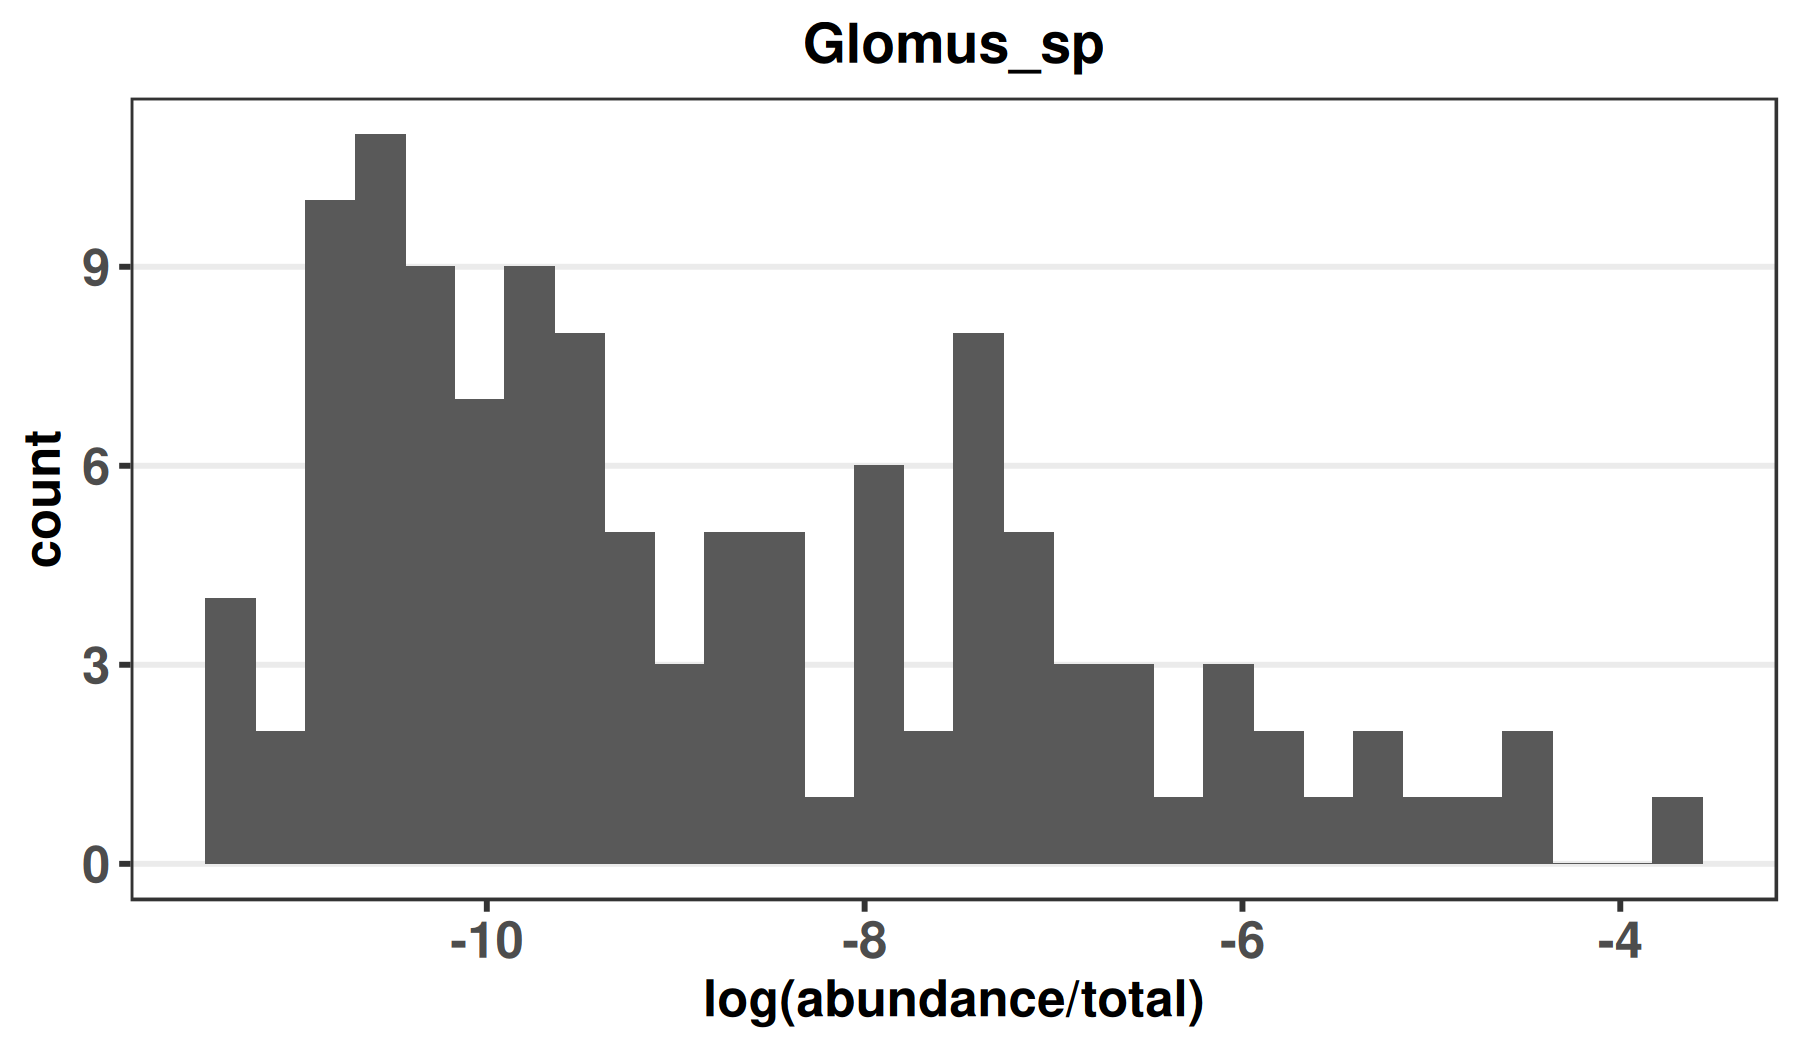

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


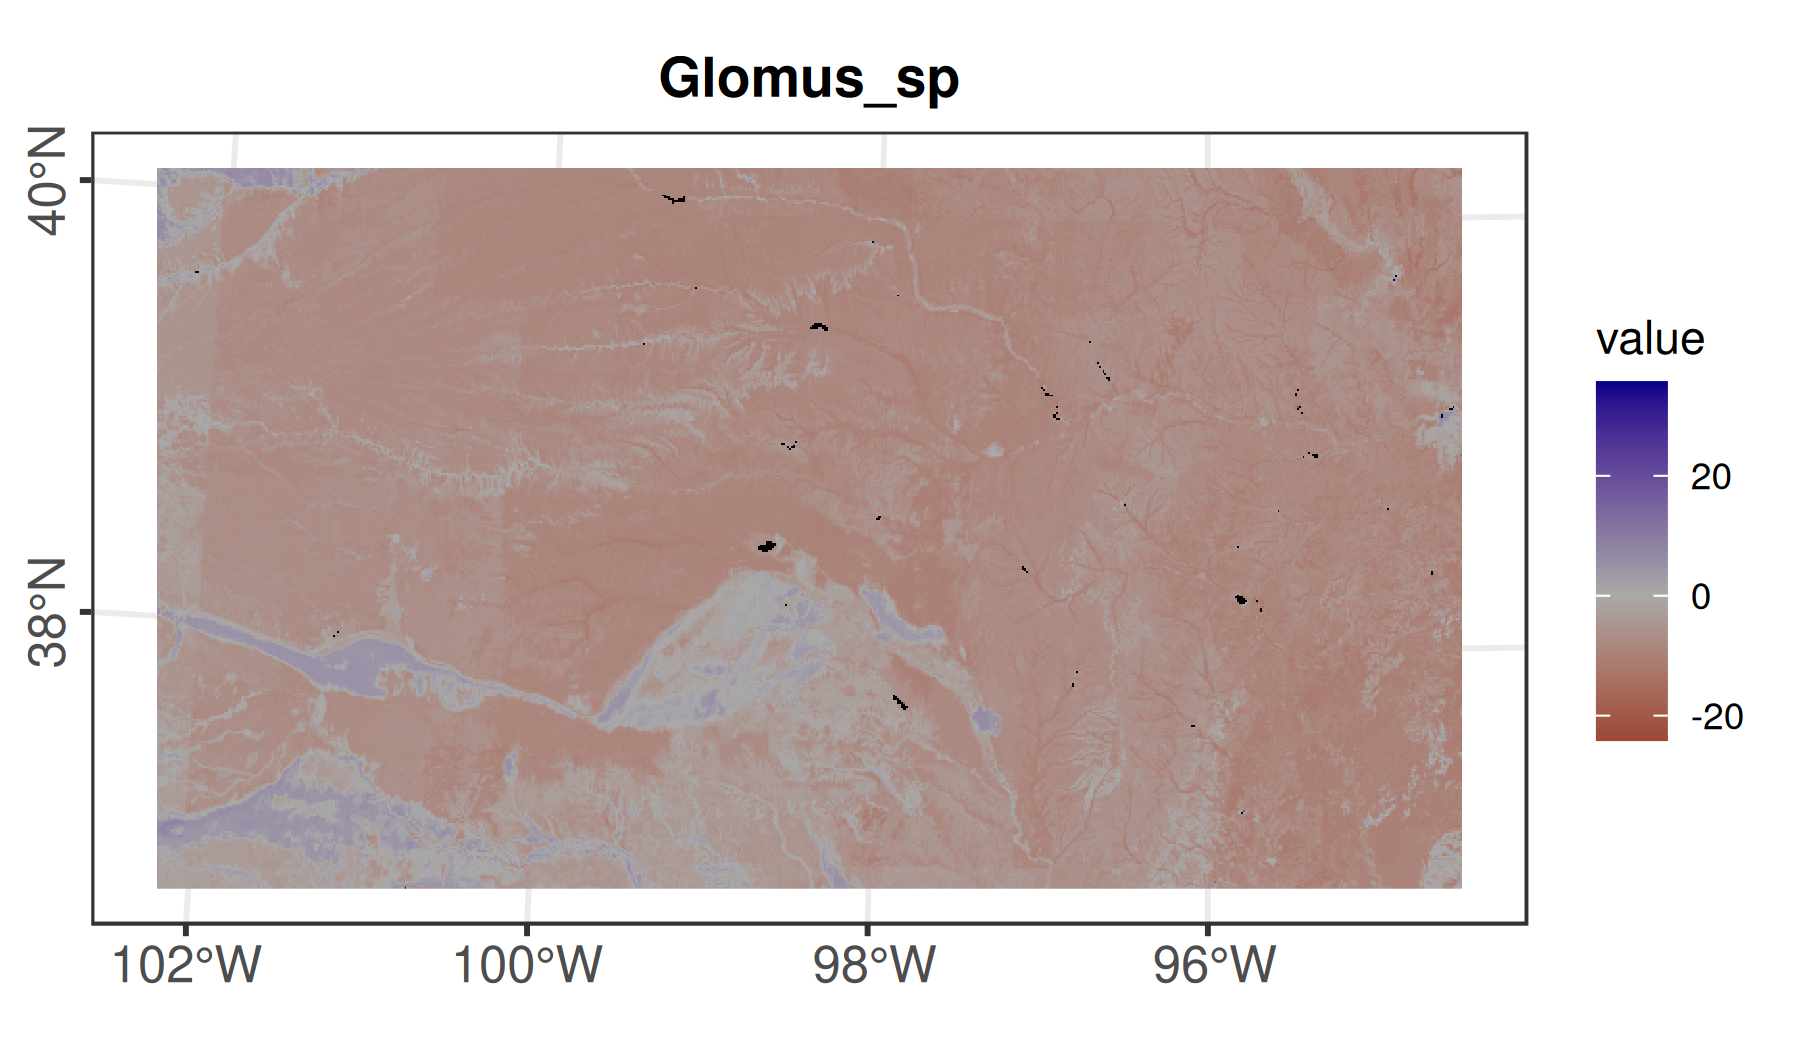


Call:
glm(formula = proportion ~ aws0_30 + rootznemc + soc0_30 + chirps, 
    family = gaussian(link = "log"), data = dataset[dataset$Species == 
        species, ])

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -3.0716023  3.8236124  -0.803    0.425
aws0_30     -0.1416253  0.0918629  -1.542    0.128
rootznemc    0.0322424  0.0367509   0.877    0.384
soc0_30      0.0002681  0.0003879   0.691    0.492
chirps      -0.0026326  0.0038648  -0.681    0.498

(Dispersion parameter for gaussian family taken to be 6.53461e-07)

    Null deviance: 4.4319e-05  on 65  degrees of freedom
Residual deviance: 3.9769e-05  on 61  degrees of freedom
AIC: -745.96

Number of Fisher Scoring iterations: 6

Analysis of Deviance Table (Type II tests)

Response: proportion
          LR Chisq Df Pr(>Chisq)  
aws0_30    2.77452  1    0.09578 .
rootznemc  1.45412  1    0.22787  
soc0_30    0.90088  1    0.34255  
chirps     0.54877  1    0.45882  
---
Signif. codes:  0 ‘***’ 0.001 ‘

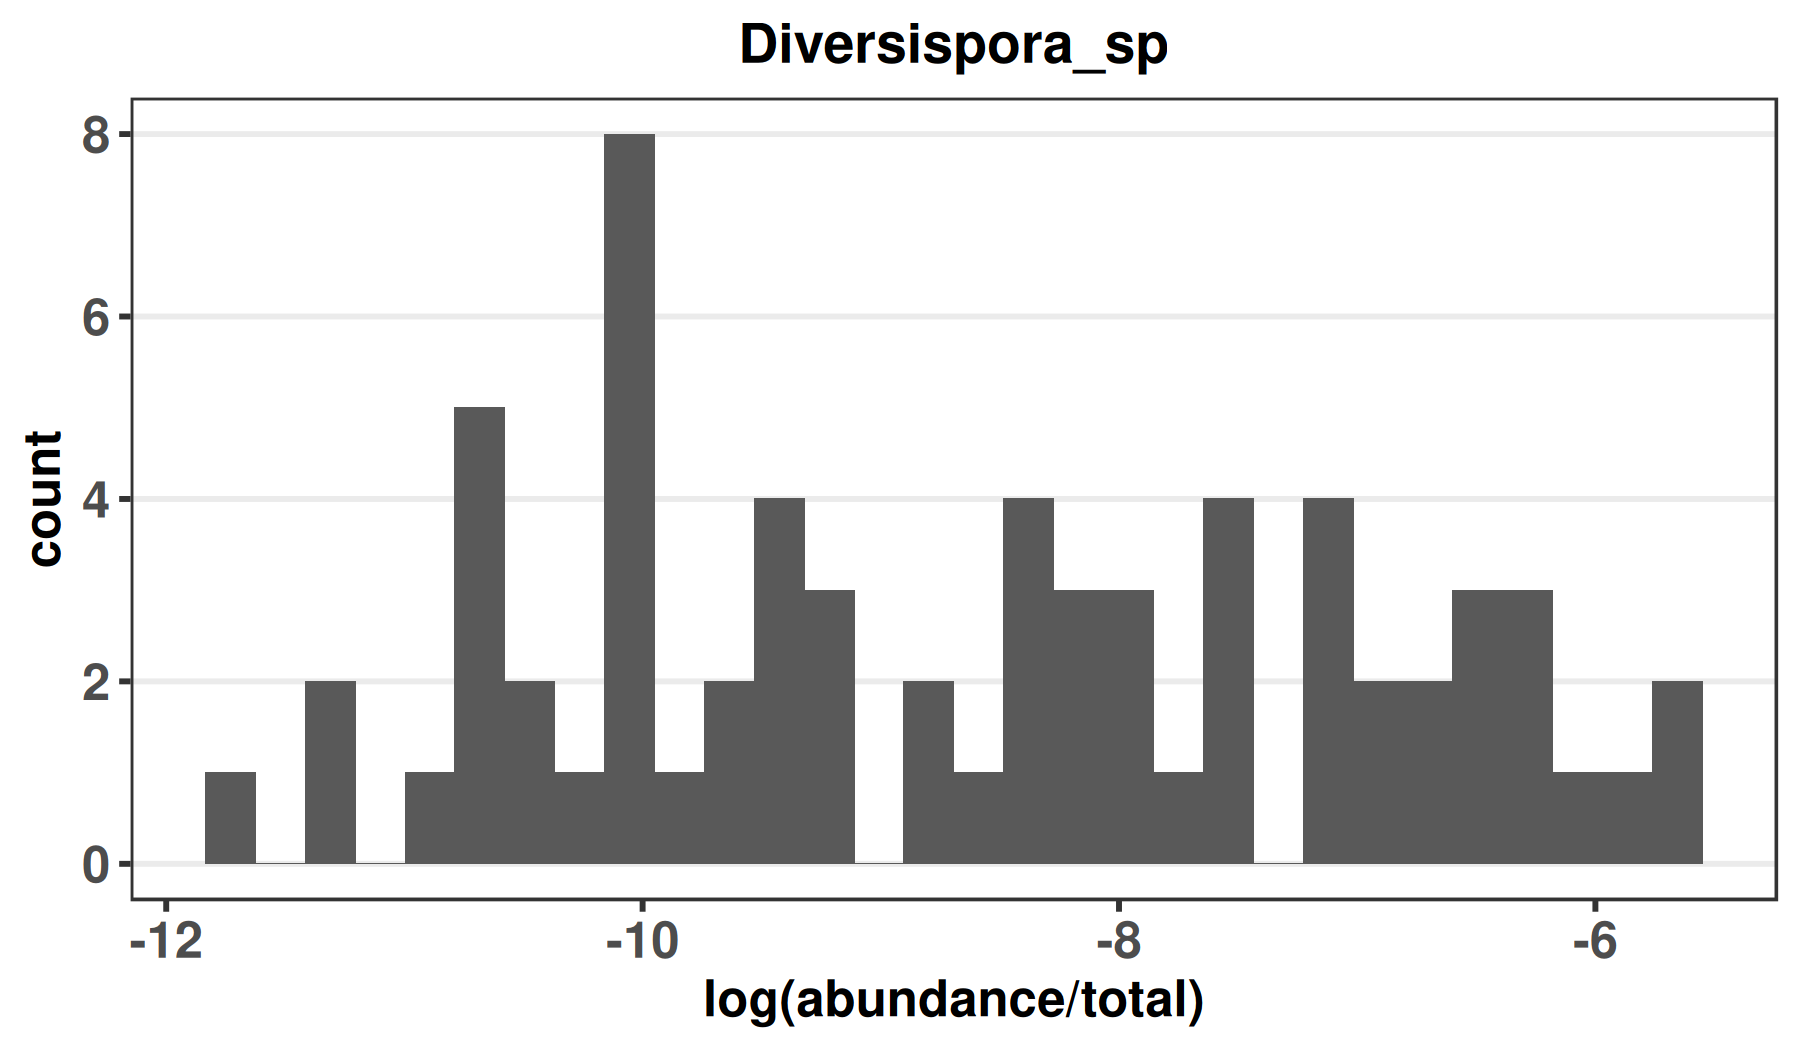

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


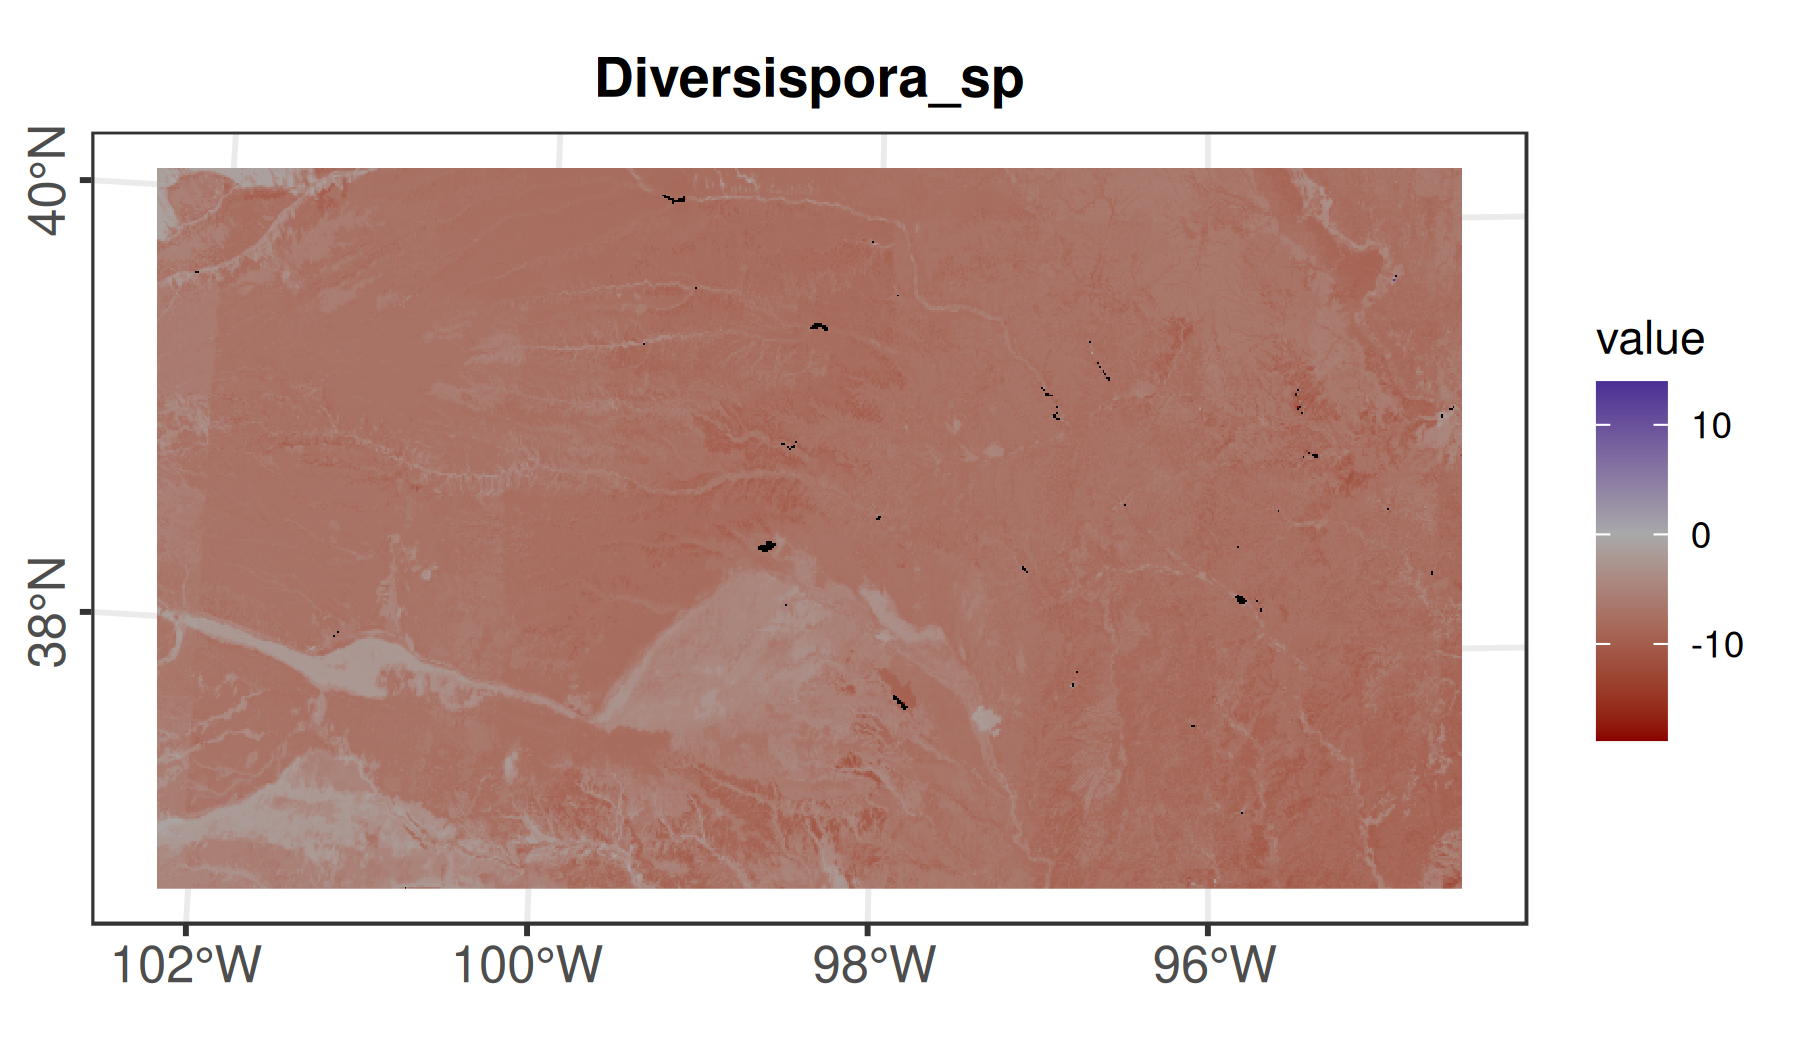


Call:
glm(formula = proportion ~ aws0_30 + rootznemc + soc0_30 + chirps, 
    family = gaussian(link = "log"), data = dataset[dataset$Species == 
        species, ])

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -35.477645  43.607204  -0.814    0.419
aws0_30       0.257359   0.682559   0.377    0.708
rootznemc    -0.037126   0.244254  -0.152    0.880
soc0_30       0.001160   0.002386   0.486    0.629
chirps        0.012623   0.046334   0.272    0.786

(Dispersion parameter for gaussian family taken to be 3.099178e-05)

    Null deviance: 0.0019025  on 60  degrees of freedom
Residual deviance: 0.0017323  on 56  degrees of freedom
AIC: -453.51

Number of Fisher Scoring iterations: 13

Analysis of Deviance Table (Type II tests)

Response: proportion
          LR Chisq Df Pr(>Chisq)
aws0_30    0.03635  1     0.8488
rootznemc  0.02447  1     0.8757
soc0_30    1.79982  1     0.1797
chirps     0.03646  1     0.8486


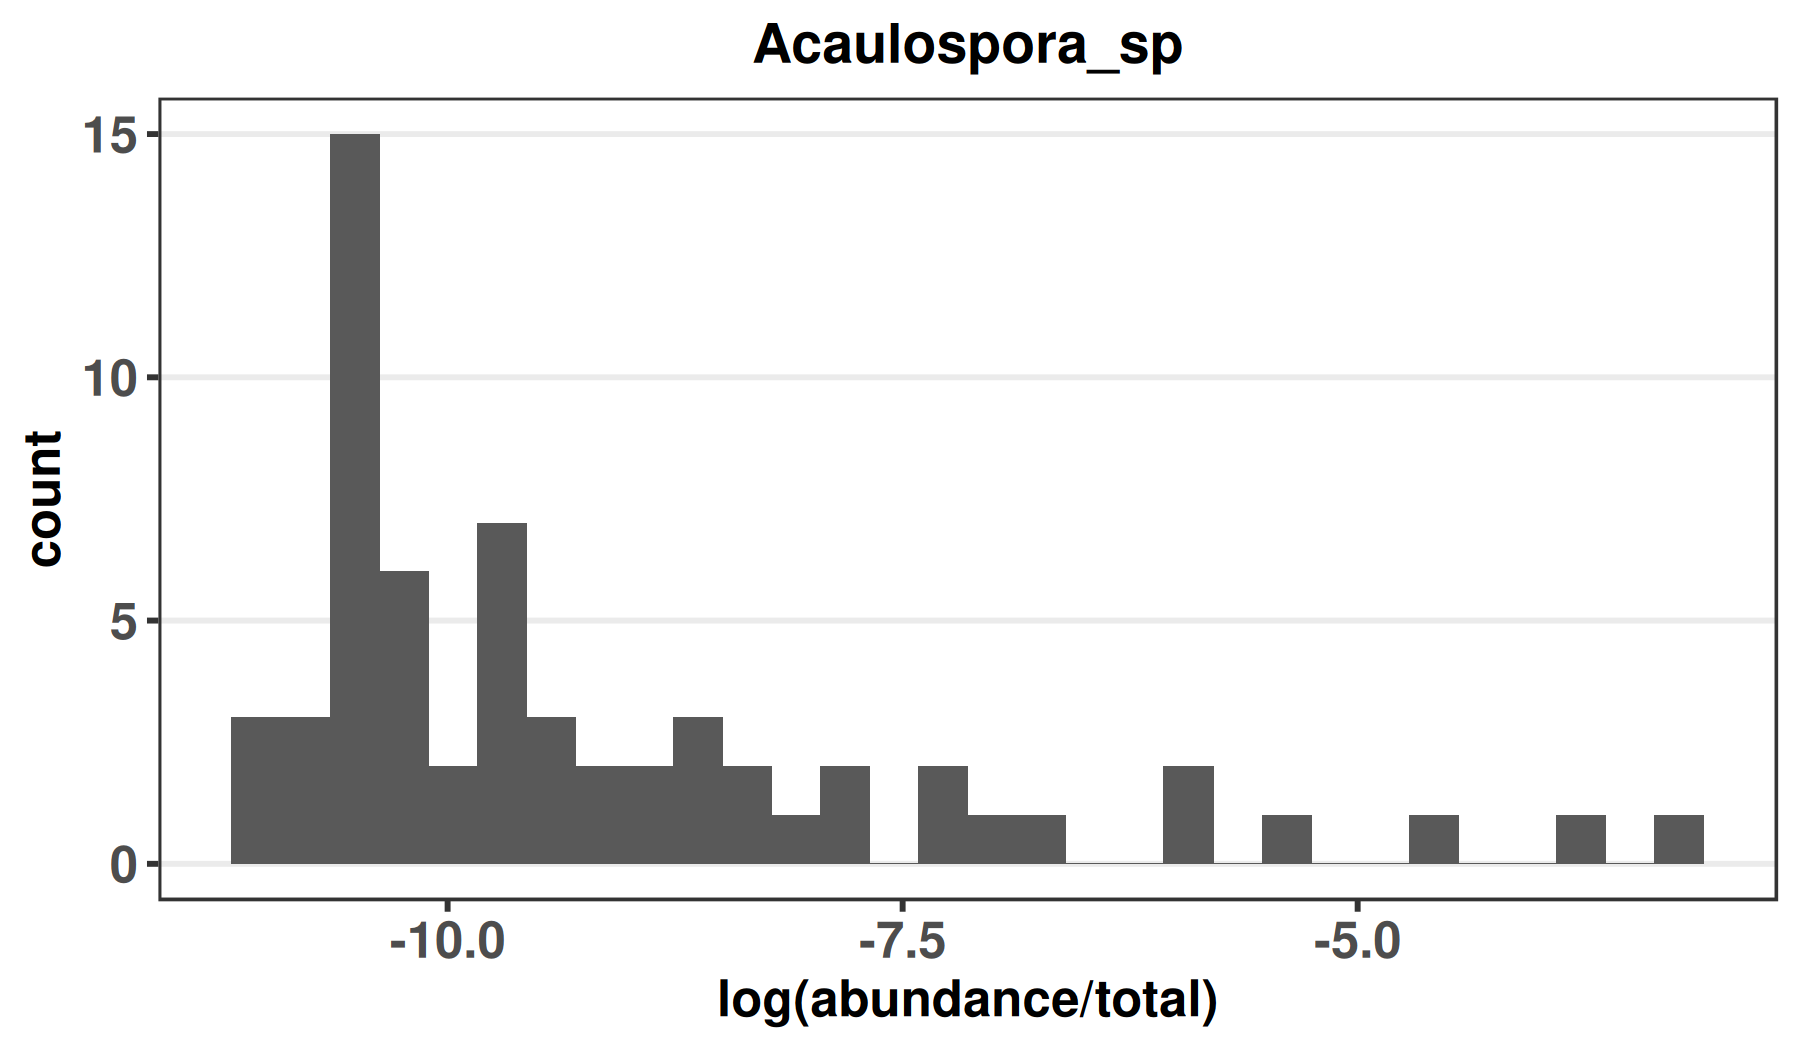

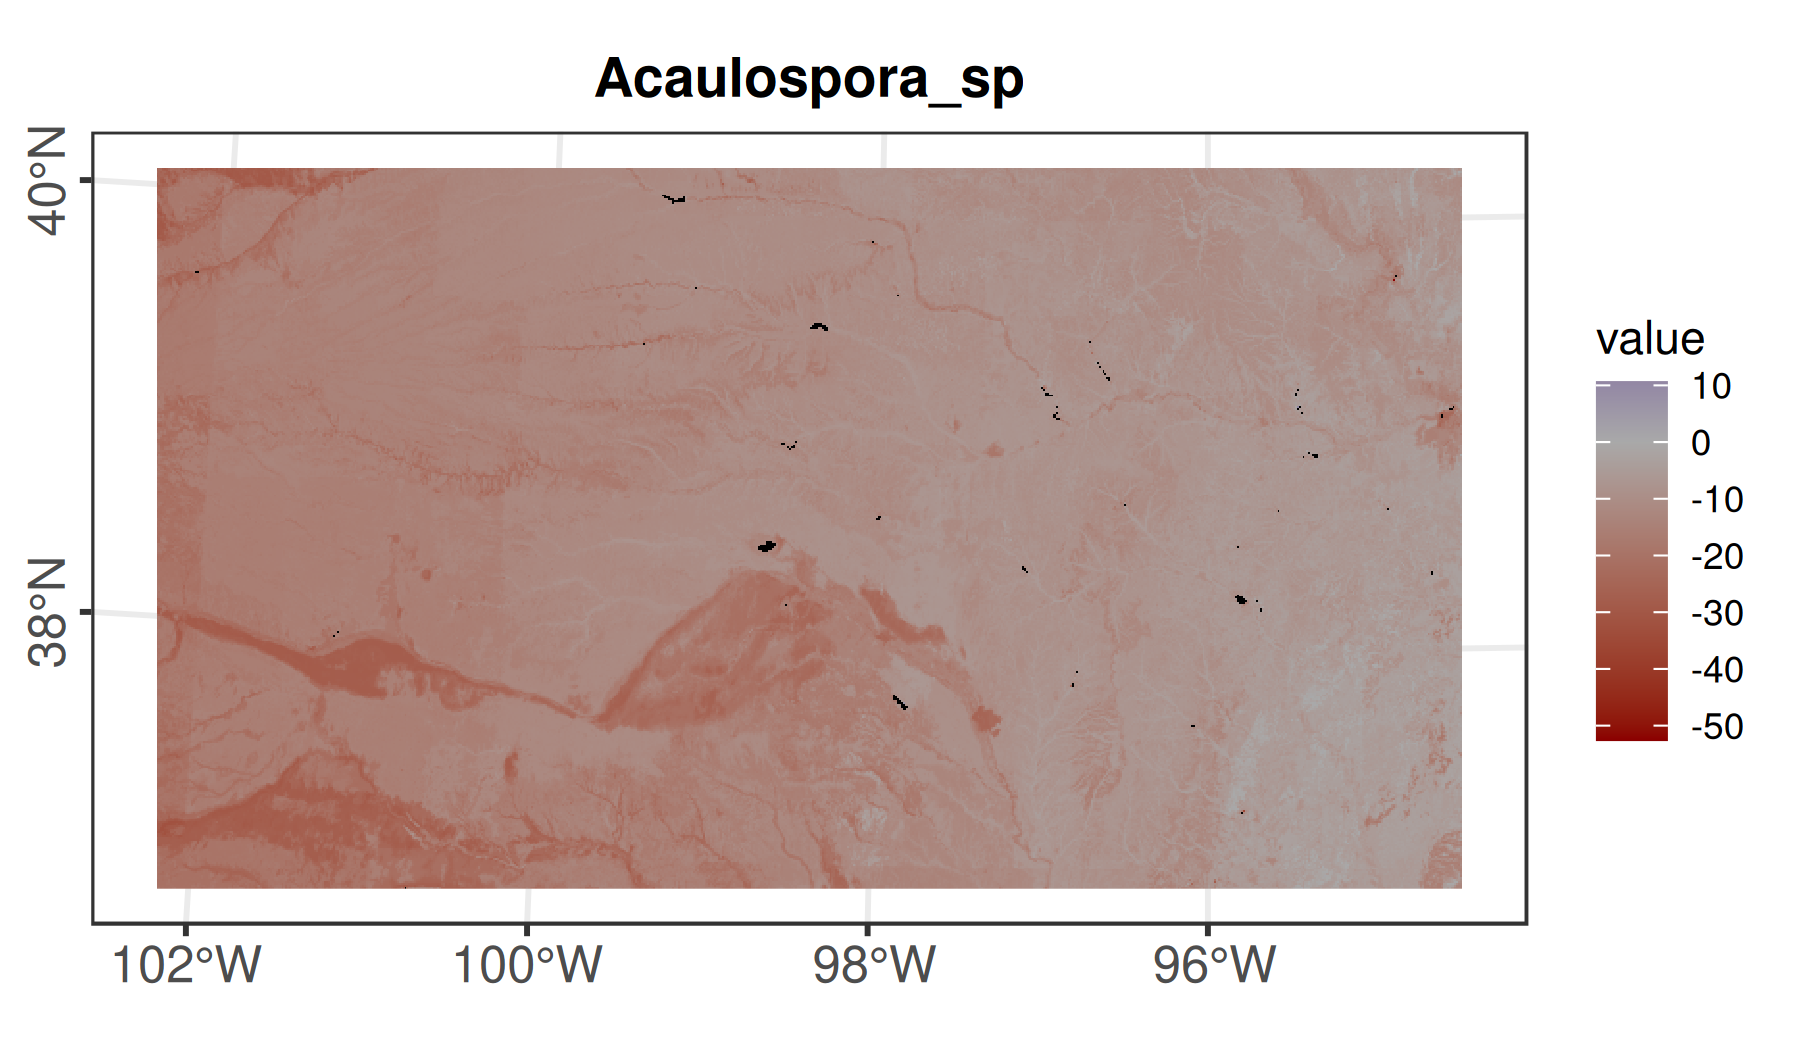

In [34]:
species_names <- c(
  "Rhizoglomus_sp", "Claroideoglomus_sp", "Septoglomus_sp",
  "Glomus_sp", "Diversispora_sp", "Acaulospora_sp"
)
for(species in species_names) {
  histogram_plot <- ggplot(data = dataset[dataset$Species == species, ]) +
    geom_histogram(aes(x = log(abundance/total))) +
    labs(title = species)
  print(histogram_plot)

  model <- glm(
    proportion ~
      aws0_30 +
      # pwsl1pomu +
      rootznemc +
      soc0_30 +
      # droughty +
      # tmax +
      # tmin +
      # tmean +
      # vpdmax +
      # vpdmin +
      chirps
    ,
    family = gaussian(link = "log"),
    data = dataset[dataset$Species == species, ]
  )
  print(summary(model))
  print(Anova(model, type = 2))

  output <- predict(kansas_gis_dataset, model)
  niche_model_map <- ggplot() +
    geom_spatraster(data = output, aes(fill = lyr1)) +
    labs(x = NULL, y = NULL, title = species) +
    scale_x_continuous(breaks = seq(-180, 180, 2)) +
    scale_y_continuous(breaks = seq(-90, 90, 2)) +
    scale_fill_gradient2(
      low = "darkred",
      mid = "darkgrey",
      high = "darkblue",
      na.value = "black",
      midpoint = 0
    ) +
    theme(
      legend.position = "right",
      legend.direction = "vertical",
      axis.text.y = element_text(angle = 90, hjust = 0.5)
    )
  print(niche_model_map)
}

In [37]:
dbDisconnect(con, shutdown = TRUE)